In [942]:
%pylab inline
import seaborn as sns
import numpy as np
import pandas as pd
import cPickle as pickle
from irm import cvpipelineutil
import sklearn.neighbors
import scipy.sparse
import irm
sns.set_style('whitegrid')
import scipy.stats
from matplotlib.collections import LineCollection


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [473]:
neurons_data = pickle.load(open("../data/mushroombody.neurondf.pickle", 'r'))
synapse_data = pickle.load(open("../data/mushroombody.synapsesdf.pickle", 'r'))
basicmat_data = pickle.load(open("../data/mushroombody.cleandata.pickle", 'r'))
tbar_df = synapse_data['tbar_df']
connections_df = synapse_data['connections_df']
neurons_df = neurons_data['neurondf']


# Rosette definition and distances


In [474]:
dfmerged = pd.merge( connections_df, tbar_df, left_on='tbar_id', 
                    right_on='id', suffixes=('_post', '_pre'))
dfmerged.convergent = dfmerged.convergent == 'convergent'
dfmerged.dtypes

body ID_post         int64
confidence_post    float64
flagged_post        object
loc_x_post           int64
loc_y_post           int64
loc_z_post           int64
tbar_id              int64
traced                bool
user_post           object
body ID_pre          int64
confidence_pre     float64
convergent            bool
flagged_pre         object
id                   int64
loc_x_pre            int64
loc_y_pre            int64
loc_z_pre            int64
multi               object
status              object
user_pre            object
dtype: object

In [475]:

neuronsdf = neurons_df.set_index('body ID')

vc = dfmerged['body ID_post'].value_counts()
neuronsdf['post_syn_count'] = vc

neuronsdf['name_clean'] = neuronsdf.name.apply(lambda x: str(x))

kcs_df = neuronsdf[neuronsdf.name_clean.str.contains('KC')]
kcs_bodyids = kcs_df.index.values
# srini says only convergent-annotated synapses should be used

In [476]:
dfmerged_kc_pre = dfmerged[dfmerged['body ID_pre'].isin(kcs_bodyids)].copy()
MBON_neurons = neuronsdf[neuronsdf.name_clean.str[:4] == 'MBON']

In [477]:
dfmerged_kc_pre.convergent.value_counts()

True     165734
False     33076
Name: convergent, dtype: int64

In [230]:
dfmerged_kc_pre_mbon_post = dfmerged_kc_pre[dfmerged_kc_pre['body ID_post'].isin(MBON_neurons.index.values)].copy()


In [198]:
counts = dfmerged_kc_pre_mbon_post.pivot_table(index='body ID_post', columns='convergent', 
                                               values='id', aggfunc=lambda x : len(x))
counts['total'] = counts[False] + counts[True]
counts = counts.sort_values('total', ascending=False)
counts

convergent    False   True  total
body ID_post                     
10563          1358  12152  13510
54977          1355  11824  13179
616459          878  10922  11800
3878341        1258   7441   8699
3338684        1149   7413   8562
3391197         312   3417   3729
1661302         166   1239   1405
149383611       137    669    806
8101328          85    620    705
1190582         127    254    381
5189028          14    116    130
2089450          41     70    111
4834094           5     71     76
8862577          11     12     23

In [270]:
MBON_ORDER = [MBON_neurons.ix[a].name_clean for a in counts.index.values]
MBON_ORDER

['MBON-14-B',
 'MBON-14-A',
 'MBON-18',
 'MBON-07-B',
 'MBON-07-A',
 'MBON-X',
 'MBON-19-A',
 'MBON-10?',
 'MBON-19-B',
 'MBON-06',
 'MBON-17-A-alpha prime',
 'MBON-11-R',
 'MBON-17-B-alpha prime',
 'MBON-11-L']

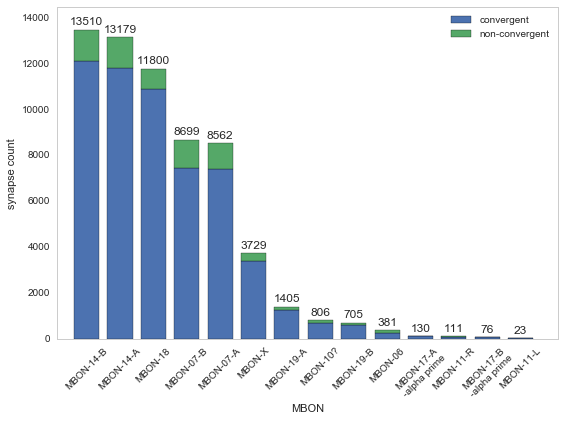

In [167]:
current_palette = sns.color_palette()
fig = pylab.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ind = np.arange(len(counts))
width = 0.75
p1 = ax.bar(ind, np.array(counts[True]), width, color=current_palette[0], label='convergent')
p2 = ax.bar(ind, np.array(counts[False]), width,color=current_palette[1],  label='non-convergent',
             bottom=np.array(counts[True]))
for i in ind:
    c = counts.iloc[i]
    ax.text(i + width/2, c.total + 200, str(c.total), horizontalalignment='center', fontsize=12)
pylab.legend()
ax.set_ylabel('synapse count')
ax.set_xlabel('MBON')
ax.set_xticks(ind + width/2.0)
names = [MBON_neurons.ix[a].name_clean for a in counts.index.values]
for i in range(len(counts)):
    if '-alpha' in names[i]:
        names[i] = names[i].replace("-alpha", "\n-alpha")
    
ax.set_xticklabels(names, rotation=45)
ax.set_ylim(0, 14500)
ax.set_xlim(-0.5, len(counts)+0.5)
ax.grid(0)
fig.tight_layout()
fig.savefig("rosette kc datascience.synapses_per_mbon.pdf")

In [231]:
dfmerged_kc_pre_mbon_post['name_clean_pre'] = dfmerged_kc_pre_mbon_post['body ID_pre'].apply(lambda x : neuronsdf.ix[x].name_clean)

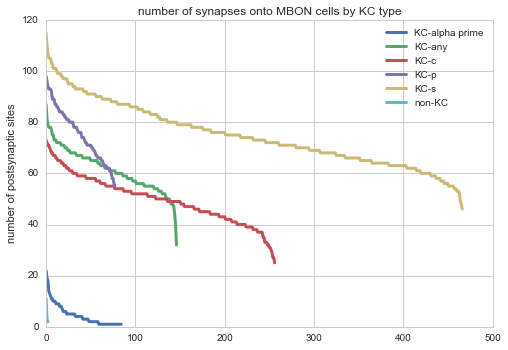

In [236]:
for ncp, df in dfmerged_kc_pre_mbon_post.groupby('name_clean_pre'):

    a = df['body ID_pre'].value_counts()
    pylab.plot(np.sort(a)[::-1], label=ncp, linewidth=3)
    pylab.ylabel("number of postsynaptic sites")
pylab.legend()
pylab.title("number of synapses onto MBON cells by KC type")


34959 467
5875 78
9049 147
12825 257
392 85


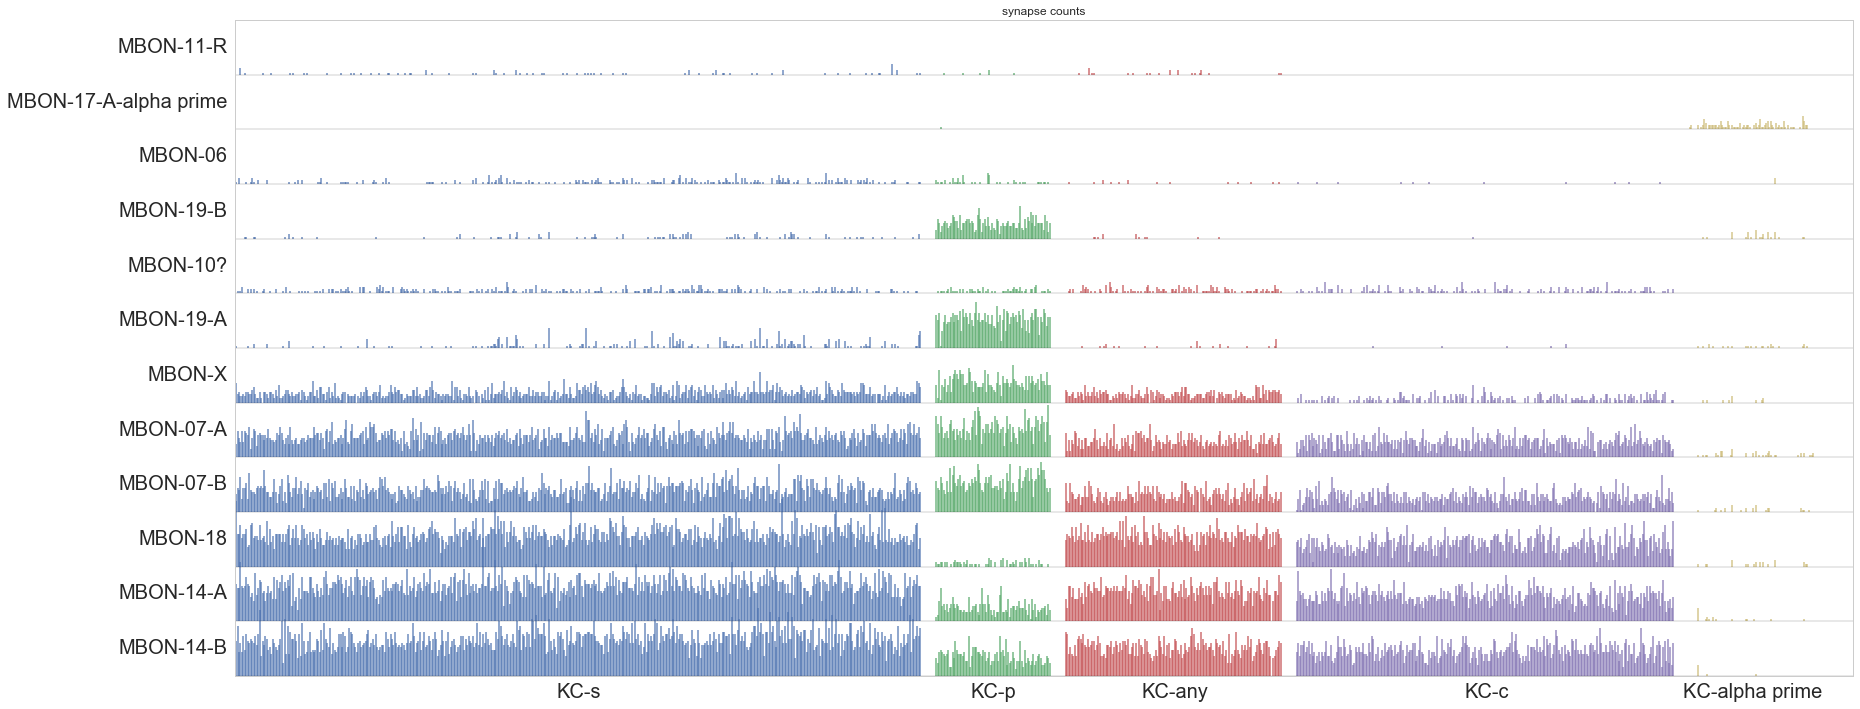

In [291]:
# KC/MBON connectivity:
from matplotlib.collections import LineCollection

group_names = ['KC-s', 'KC-p', 'KC-any', 'KC-c', 'KC-alpha prime']
running_pos = 0

vheight = 25
mbon_positions = {n : v*vheight for v, n in enumerate(MBON_ORDER)}

lines_by_group = {}
group_centers= {}
    
for g in group_names:
    lines = []
    a = dfmerged_kc_pre_mbon_post[dfmerged_kc_pre_mbon_post.name_clean_pre == g]

    
    kcmbon = a.pivot_table(index='body ID_pre', columns='body ID_post', 
                                                   values='id', aggfunc=lambda x : len(x))
    print len(a), len(kcmbon)
    for kpos, (ri, r), in enumerate(kcmbon.iterrows()):
        for mpos, (mi, ri) in enumerate(r.iteritems()):
            mbon_pos = mbon_positions[MBON_neurons.ix[mi].name_clean]
            if np.isfinite(ri):
                lines.append([(running_pos, mbon_pos), (running_pos, mbon_pos+ri)])
        running_pos += 1
    group_centers[g] = running_pos - len(kcmbon)/2
    running_pos += 10
    lines_by_group[g] = lines
    
    
fig = pylab.figure(figsize=(26, 10))
ax = fig.add_subplot(1, 1, 1)

for p in [mbon_positions[n] for n in MBON_ORDER]:
    ax.axhline(p, c='k', alpha=0.1)

xticks = []
for gi, g in enumerate(group_names):
    line_segments = LineCollection(lines_by_group[g], color=current_palette[gi], alpha=0.7)
    ax.add_collection(line_segments)
    xticks.append(group_centers[g])
ax.set_yticks(np.array([mbon_positions[n] for n in MBON_ORDER]) + vheight/2.0)
ax.set_yticklabels(MBON_ORDER, fontsize=20)
ax.set_xticks(xticks)
ax.set_xticklabels(group_names, fontsize=20)
ax.set_xlim(0, 1100)
ax.set_ylim(0, 300)
ax.grid(False)
ax.set_title("synapse counts")
fig.tight_layout()
fig.savefig("rosette kc datascience.kc_syn_by_mbon.pdf")


# rosettes

In [54]:
#warning takes a long time
rosette_res = []
MAX_DIST = 200
pos = 0
for ni, n in MBON_neurons.iterrows():
    for convergent in [False, True]:
        if convergent:
            kcs_pre_df = dfmerged_kc_pre[(dfmerged_kc_pre['convergent'] )]
        else:
            kcs_pre_df = dfmerged_kc_pre

        mbons_post = kcs_pre_df[(kcs_pre_df['body ID_post'] == ni) ].copy()

        postsyn_vector = np.zeros((len(mbons_post), 3))
        postsyn_vector[:, 0] = mbons_post.loc_x_post
        postsyn_vector[:, 1] = mbons_post.loc_y_post
        postsyn_vector[:, 2] = mbons_post.loc_z_post
        
        dists = sklearn.metrics.pairwise.euclidean_distances(postsyn_vector)
        idx = np.triu_indices(dists.shape[0], 1)
        dflat = dists[idx]
        dflat = dflat[dflat < MAX_DIST]

        dist_df = pd.DataFrame({'dists' : dflat, 'mbon': n.name_clean, 'body ID_post': ni,
                                'convergent': convergent, 'shuffle' : False})
        rosette_res.append(dist_df)
        
        # shuffle
        postsyn_vector_shuffle = postsyn_vector.copy()
        for i in range(3):
            postsyn_vector_shuffle[:, i] = np.random.permutation(postsyn_vector_shuffle[:, i])
        dists = sklearn.metrics.pairwise.euclidean_distances(postsyn_vector_shuffle)
        idx = np.triu_indices(dists.shape[0], 1)
        dflat = dists[idx]
        dflat = dflat[dflat < MAX_DIST]

        dist_df = pd.DataFrame({'dists' : dflat, 'mbon': n.name_clean, 'body ID_post': ni,
                                'convergent': convergent, 'shuffle': True})
        rosette_res.append(dist_df)
        
        
        
    pos +=1


In [55]:
alldist_df = pd.concat(rosette_res)

In [56]:
alldist_df.mbon.value_counts()

MBON-18                  933767
MBON-14-B                897145
MBON-14-A                835865
MBON-07-B                305814
MBON-07-A                298507
MBON-X                    85946
MBON-19-A                 32459
MBON-10?                  22502
MBON-19-B                 11784
MBON-17-A-alpha prime      1219
MBON-06                     705
MBON-17-B-alpha prime       435
MBON-11-R                   233
MBON-11-L                    22
Name: mbon, dtype: int64

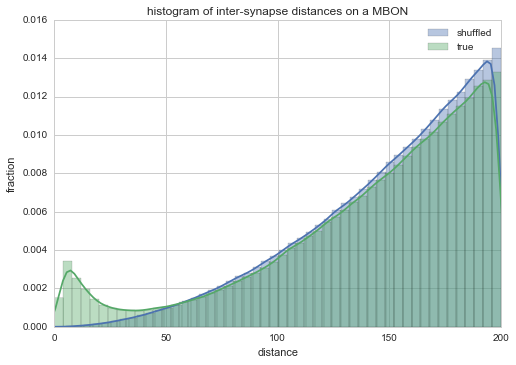

In [173]:
sns.distplot(alldist_df[alldist_df.shuffle].dists, label='shuffled', norm_hist=False)
sns.distplot(alldist_df[~alldist_df.shuffle].dists, label='true', norm_hist=False)
pylab.xlabel('distance')
pylab.ylabel('fraction')
pylab.title("histogram of inter-synapse distances on a MBON")
pylab.xlim(0, 200)
pylab.legend()

(0, 4000)

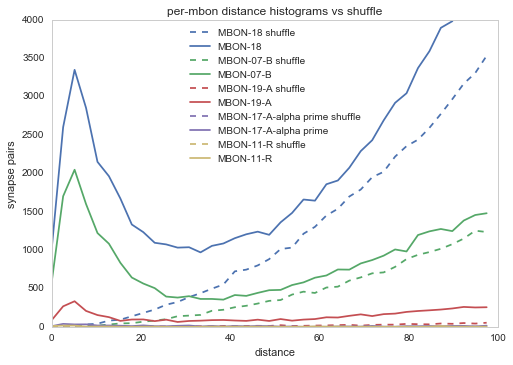

In [194]:
mbon_names_by_size = alldist_df.mbon.value_counts().index.values
fig = pylab.figure()
ax = fig.add_subplot(1, 1, 1)
alldist_df_lt = alldist_df[alldist_df.dists<100]
bins=np.linspace(0, 100, 40)
for i, mbon_id in enumerate(mbon_names_by_size[::3]):
    d = alldist_df_lt[alldist_df_lt.mbon == mbon_id]
    ds = d[d.shuffle]
    hist, edgs = np.histogram(ds.dists, bins=bins)
    ax.plot(edgs[:-1], hist, color=current_palette[i], linestyle='--', 
                label='%s shuffle' % mbon_id)
    
    dns = d[~d.shuffle]

    hist, edgs = np.histogram(dns.dists, bins=bins)
    ax.plot(edgs[:-1], hist, color=current_palette[i], label='%s' % mbon_id)
pylab.legend(loc='upper center')
ax.set_title("per-mbon distance histograms vs shuffle")
ax.set_ylabel('synapse pairs')
ax.set_xlabel('distance')
ax.grid(False)
ax.set_ylim(0, 4000)

In [ ]:
#res = []
rosette_res = []

for convergent in [False, True]:
    if convergent:
        kcs_pre_df = dfmerged[(dfmerged['body ID_pre'].isin(kcs_bodyids)) & (dfmerged['convergent'] == 'convergent')]
    else:
        kcs_pre_df = dfmerged[(dfmerged['body ID_pre'].isin(kcs_bodyids))]

    for ni, n in neuronsdf[neuronsdf.name_clean.str[:4] == 'MBON'].iterrows():
        for thold in [10, 20, 30, 40]:
            mbons_post = kcs_pre_df[(kcs_pre_df['body ID_post'] == ni) ].copy()

            postsyn_vector = np.zeros((len(mbons_post), 3))
            postsyn_vector[:, 0] = mbons_post.loc_x_post
            postsyn_vector[:, 1] = mbons_post.loc_y_post
            postsyn_vector[:, 2] = mbons_post.loc_z_post
            ng = sklearn.neighbors.radius_neighbors_graph(postsyn_vector, thold, include_self=True)
            cc = scipy.sparse.csgraph.connected_components(ng)[1]
            #unique = np.array(pd.value_counts(cc))

            mbons_post['rosette'] = cc
            mbons_post['rosette_thold'] = thold
            mbons_post['post_name'] = n.name_clean
            mbons_post['body ID_post'] == ni
            mbons_post['convergent_filtered'] = convergent

            rosette_res.append(mbons_post)
            a = pd.value_counts(pd.value_counts(cc))
            a.index.name = "cluster_size"
            d = pd.DataFrame(a).reset_index()
            d.columns = ['cluster_size', 'count']
            d['thold'] = thold
            d['post_name'] = n.name_clean
            d['body ID_post'] = ni

            #res.append(d)
#cluster_sizes = pd.concat(res)

rosette_df = pd.concat(rosette_res).reset_index()
rosette_df['rosette_id'] = rosette_df.apply(lambda x : "%s:%d" % (x.post_name, 
                                                                  x.rosette), 
                                            axis=1)


# precomputed rosette analysis

Using the python preprocessing script 

In [322]:
kc_mbon_rosettes = pickle.load(open("../data/mushroombody.KC-MBON.rosette.df.pickle", 'r'))
rosette_df = kc_mbon_rosettes['rosette_df']


In [323]:
ROSETTE_THRESHOLD = 40
pre_ids_unique = np.unique(rosette_df['body ID_pre'])
pre_ids_to_pos = {k:v for v, k in enumerate(pre_ids_unique)}
KCN = len(pre_ids_unique)

pre_ids_names = []

for pi in pre_ids_unique:
    a = neurons_df[neurons_df['body ID'] == pi].iloc[0]
    pre_ids_names.append(a['name'])
pre_ids_names = np.array(pre_ids_names)
rand_idx = np.argsort(pre_ids_names)# np.random.permutation(KCN)
pre_ids_names_sorted = pre_ids_names[rand_idx]

In [324]:
rosettes_th = rosette_df[(rosette_df.rosette_thold == ROSETTE_THRESHOLD) & (~rosette_df.convergent_filtered)]


(-2, 12)

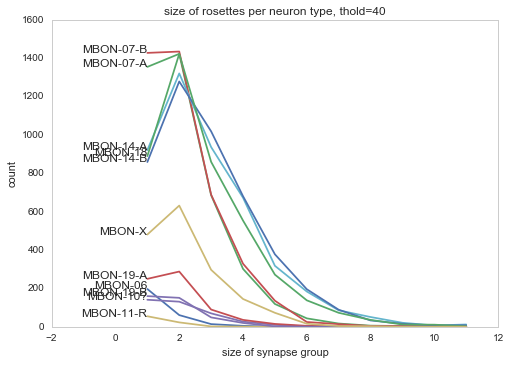

In [350]:
from adjustText import adjust_text

fig = pylab.figure()
ax = fig.add_subplot(1, 1,1)
bins = np.arange(12) + 1

#names = [MBON_neurons.ix[a].name_clean for a in counts.index.values]
#for i in range(len(counts)):
#    if '-alpha' in names[i]:
#        names[i] = names[i].replace("-alpha", "\n-alpha")
texts = []

for gi, g in rosettes_th.groupby('post_name'):
    h, _ = np.histogram(g.rosette.value_counts(), bins)
    if h[0] > 40:
        ax.plot(bins[:-1], h, label=gi)
        texts.append(ax.text(1, h[0], gi,  horizontalalignment='right'))
    else:
        ax.plot(0, 0, label=gi, c='k', linestyle='--')
    #ax.scatter(bins[:-1], h, c='k')
#pylab.legend()
#adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), 
#            ha='right')
ax.grid(False)
ax.set_xlabel("size of synapse group")
ax.set_ylabel('count')
ax.set_title("size of rosettes per neuron type, thold=%d" % ROSETTE_THRESHOLD)
ax.set_xlim(-2, np.max(bins))

In [8]:
kc_rosette_kc_mats = {}
kc_kc_mats = {}
MAX_ROSETTE_SIZE = 20
for post_name, a in  rosettes_th.groupby('post_name'):


    conn_mat = np.zeros((KCN, KCN, MAX_ROSETTE_SIZE), dtype=np.uint16)

    for rosette_id, rosette in a.groupby('rosette_id'):
        pre_ids = np.unique(rosette['body ID_pre'])
        pos = [pre_ids_to_pos[pre_id] for pre_id in pre_ids]
        #if len(rosette) > 1
        rosette_size = len(rosette)
        for i in pos:
            for j in pos:
                if i != j: # ignore same-same
                    conn_mat[i, j, rosette_size] += 1 
    kc_rosette_kc_mats[post_name] = conn_mat
    
    # now kc-kc ignoring rosette
    kc_kc_conn_mat = np.zeros((KCN, KCN))
    allpos = [pre_ids_to_pos[i] for i in a['body ID_pre'].value_counts().index.values]
    for i in allpos:
        for j in allpos:
            kc_kc_conn_mat[i, j] = 1
    kc_kc_mats[post_name] = kc_kc_conn_mat
    

29236


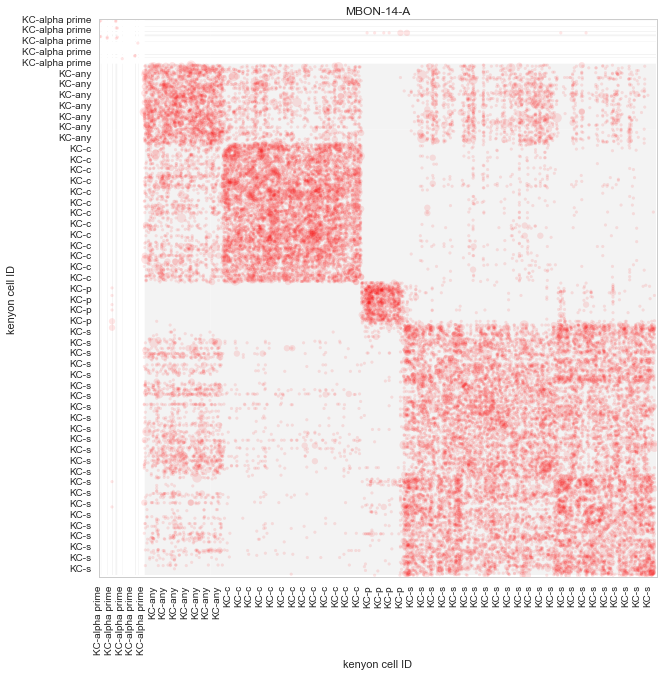

In [9]:
for mbon_name in kc_rosette_kc_mats.keys():

    fig = pylab.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    rosette_mat = kc_rosette_kc_mats[mbon_name]
    conn_mat = rosette_mat[:, :, 2:].sum(axis=2)
    
    
    kc_kc_mat = kc_kc_mats[mbon_name]
    conn_rand = conn_mat[rand_idx]
    conn_rand = conn_rand[:, rand_idx]
    
    kc_kc_sorted = kc_kc_mat[rand_idx]
    kc_kc_sorted = kc_kc_sorted[:, rand_idx]
    
    
    a = np.argwhere(conn_rand)
    print len(a)
    counts = np.array([conn_rand[i, j] for i, j in a])
    ax.scatter(a[:, 0], a[:, 1], edgecolor='none', c='r',
               s=10*counts**2, alpha=0.1)
    ax.set_xlim(0, KCN)
    ax.set_ylim(KCN, 0)
    
    im = np.ones((kc_kc_sorted.shape[0], kc_kc_sorted.shape[1], 4))
    im[:, :, 2] = 1-kc_kc_sorted
    im[:, :, 0] = 1-kc_kc_sorted
    im[:, :, 1] = 1-kc_kc_sorted
    im[:, :, 3] = kc_kc_sorted * 0.05
    ax.imshow(im)
    ticks = np.arange(0, len(pre_ids_names), 20)
    ax.set_yticks(ticks)
    ax.set_yticklabels(pre_ids_names_sorted[ticks])
    ax.set_xticks(ticks)
    ax.set_xticklabels(pre_ids_names_sorted[ticks], rotation=90)
    #ax.set_yticks([])
    ax.set_title(mbon_name)
    ax.grid(False)
    ax.set_xlabel("kenyon cell ID")
    ax.set_ylabel("kenyon cell ID")
    fig.savefig("kc-rosette-kc %s.png" % mbon_name, dpi=300)
    break

# More careful rosette analysis examining converged synapses

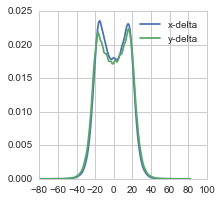

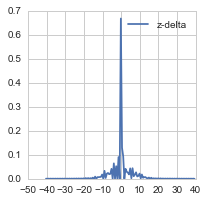

In [478]:
fig = pylab.figure(figsize=(3, 3))
sns.kdeplot(dfmerged_kc_pre.loc_x_pre- dfmerged_kc_pre.loc_x_post, label='x-delta')  
sns.kdeplot(dfmerged_kc_pre.loc_y_pre- dfmerged_kc_pre.loc_y_post, label='y-delta')  
#sns.kdeplot(dfmerged_kc_pre.loc_z_pre- dfmerged_kc_pre.loc_z_post)  
pylab.legend()

fig = pylab.figure(figsize=(3, 3))
sns.kdeplot(dfmerged_kc_pre.loc_z_pre- dfmerged_kc_pre.loc_z_post, label='z-delta')  
#sns.kdeplot(dfmerged_kc_pre.loc_z_pre- dfmerged_kc_pre.loc_z_post)  
pylab.legend()


In [492]:
#warning takes a long time
rosette_res = []
MAX_DIST = 140
pos = 0
for ni, n in MBON_neurons.iterrows():
    #if '14' not in n.name_clean:
    #    continue # DEBUG
    kcs_pre_df = dfmerged_kc_pre

    mbons_post = kcs_pre_df[(kcs_pre_df['body ID_post'] == ni) ].copy()

    # post-synaptic distance matrix
    postsyn_vector = np.zeros((len(mbons_post), 3))
    postsyn_vector[:, 0] = mbons_post.loc_x_post
    postsyn_vector[:, 1] = mbons_post.loc_y_post
    postsyn_vector[:, 2] = mbons_post.loc_z_post
    
    post_dists = sklearn.metrics.pairwise.euclidean_distances(postsyn_vector)
    
    # pre-synaptic distance matrix
    presyn_vector = np.zeros((len(mbons_post), 3))
    presyn_vector[:, 0] = mbons_post.loc_x_pre
    presyn_vector[:, 1] = mbons_post.loc_y_pre
    presyn_vector[:, 2] = mbons_post.loc_z_pre
    
    pre_dists = sklearn.metrics.pairwise.euclidean_distances(presyn_vector)
    
    # generate a matrix with the same shape as the distance matrix
    # telling us which synapses are being measured
    tbar_id_mat = np.array(np.meshgrid(mbons_post['tbar_id'], mbons_post['tbar_id']))
    tbar_id_mat = np.swapaxes(tbar_id_mat, 0, 2)
    
    idx = np.triu_indices(pre_dists.shape[0], 1)
    post_dflat = post_dists[idx]
    pre_dflat = pre_dists[idx]
    tbar_ids = tbar_id_mat[idx]

    # just select far-away subset:
    closer_idx = (pre_dflat < MAX_DIST) | (post_dflat < MAX_DIST)
    post_dflat = post_dflat[closer_idx]
    pre_dflat = pre_dflat[closer_idx]
    tbar_ids = tbar_ids[closer_idx]

    dist_df = pd.DataFrame({'pre_dist' : pre_dflat, 
                            'post_dist' : post_dflat, 
                            'tbar_id_1' : tbar_ids[:, 0], 
                            'tbar_id_2' : tbar_ids[:, 1],
                            'mbon': n.name_clean, 'body ID_post': ni})
    rosette_res.append(dist_df)

    pos +=1
    


In [493]:
alldist_df = pd.concat(rosette_res)
len(alldist_df)

467240

In [ ]:
    ng = sklearn.neighbors.radius_neighbors_graph(postsyn_vector, thold, include_self=True)
    cc = scipy.sparse.csgraph.connected_components(ng)[1]

In [494]:
tbar_convergent_df = tbar_df[['id', 'convergent']].copy()
tbar_convergent_df.convergent = (tbar_convergent_df.convergent == "convergent")
tbar_convergent_df = tbar_convergent_df.set_index('id')
a = alldist_df.join(tbar_convergent_df, on='tbar_id_1', )
a = a.rename(columns={"convergent" : "convergent_1"})
b = a.join(tbar_convergent_df, on='tbar_id_2', )
b = b.rename(columns={"convergent" : "convergent_2"})
alldist_df = b

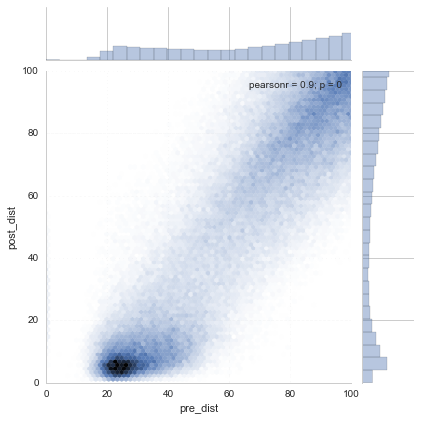

In [495]:
sns.jointplot(alldist_df.pre_dist, alldist_df.post_dist, xlim=(0, 100), ylim=(0, 100), kind="hex")

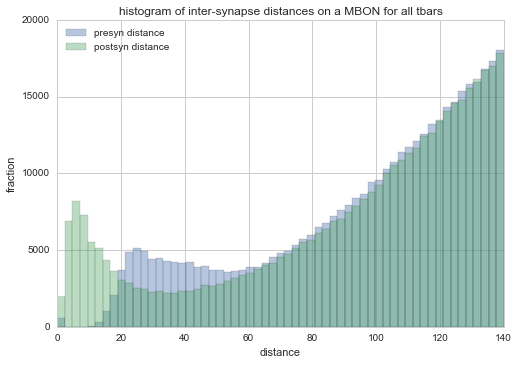

In [496]:
dist_bins = np.linspace(0, MAX_DIST, 60)
sns.distplot(alldist_df.pre_dist, label="presyn distance", bins=dist_bins, kde=False)
sns.distplot(alldist_df.post_dist, label='postsyn distance', bins=dist_bins, kde=False)

#sns.distplot(alldist_df[~alldist_df.shuffle].dists, label='true', norm_hist=False)
pylab.xlabel('distance')
pylab.ylabel('fraction')
pylab.title("histogram of inter-synapse distances on a MBON for all tbars")
pylab.xlim(0, MAX_DIST)
pylab.legend(loc='upper left')

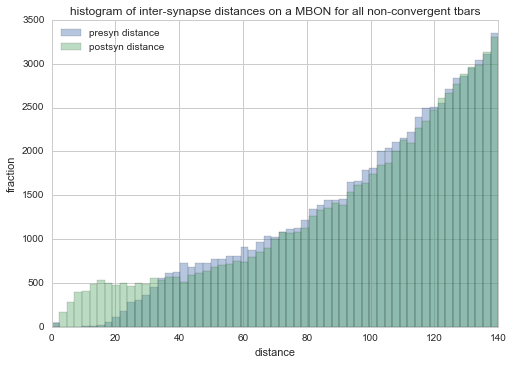

In [501]:
one_non_conv_df = alldist_df[(alldist_df.convergent_1 == False) | (alldist_df.convergent_2 == False)]
sns.distplot(one_non_conv_df.pre_dist, label="presyn distance", bins =dist_bins, kde=False)
sns.distplot(one_non_conv_df.post_dist, label='postsyn distance', bins=dist_bins, kde=False)

#sns.distplot(alldist_df[~alldist_df.shuffle].dists, label='true', norm_hist=False)
pylab.xlabel('distance')
pylab.ylabel('fraction')
pylab.title("histogram of inter-synapse distances on a MBON for all non-convergent tbars")
pylab.xlim(0, MAX_DIST)
pylab.legend(loc='upper left')

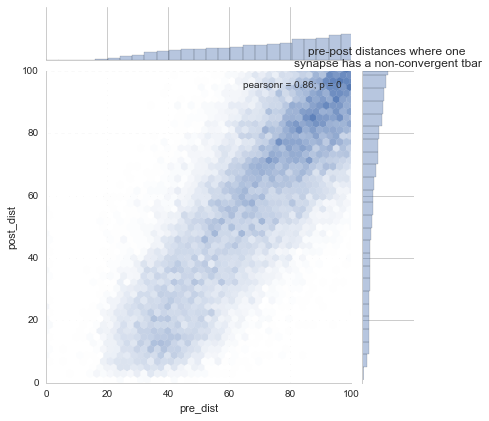

In [502]:
sns.jointplot(one_non_conv_df.pre_dist, one_non_conv_df.post_dist, 
              xlim=(0, 100), ylim=(0, 100), kind="hex")
pylab.title("pre-post distances where one \nsynapse has a non-convergent tbar")

# investigate all synaptic spatial localization on MBON

Not just KC

In [1003]:
dfmerged_mbon_post = dfmerged[dfmerged['body ID_post'].isin(MBON_neurons.index.values)].copy()
#MBON_neurons = neuronsdf[neuronsdf.name_clean.str[:4] == 'MBON']
TGT_MBON = 'MBON-07-A'
tgt_mbon_rec = MBON_neurons[MBON_neurons.name_clean == TGT_MBON].iloc[0]
tgt_mbon_post_df = dfmerged_mbon_post[dfmerged_mbon_post['body ID_post'] == tgt_mbon_rec.name].copy()
# counts

names_df = neuronsdf[['name_clean']]
tgt_mbon_post_df = tgt_mbon_post_df.join(names_df, on='body ID_pre')\
                        .rename(columns={'name_clean' : 'name_clean_pre'})
    
    
a = tgt_mbon_post_df.groupby(['body ID_pre']).agg({'body ID_pre' : 'count', 'name_clean_pre' : 'first'})
b = a.sort_values('body ID_pre', ascending=False)


In [1004]:
print "for cell {} how many of cell type x syanpse onto it, and how many times?".format(TGT_MBON)
print b.dtypes

# THIS IS A HACK TO CLUSTER PAM AS A CELL TYPE
c = b.name_clean_pre.apply(lambda x :'PAM' if 'PAM-' in str(x) else x)
b['name_pre_summary'] = c
b.groupby('name_pre_summary').agg({'body ID_pre': ['count', 'mean', 'std', 'sum']})\
        .sort_values(('body ID_pre', 'sum'), ascending=False)

for cell MBON-07-A how many of cell type x syanpse onto it, and how many times?
body ID_pre        int64
name_clean_pre    object
dtype: object


body ID_pre                             
                            count        mean        std   sum
name_pre_summary                                              
KC-s                          467    9.760171   3.039489  4558
KC-c                          256    7.109375   2.774490  1820
KC-any                        147    7.367347   2.604216  1083
KC-p                           78   13.500000   4.189505  1053
PAM                            16   39.687500  12.631805   635
MBON-06                         1  108.000000        NaN   108
MB-DPM                          2   27.000000  11.313708    54
KC-alpha prime                 27    1.666667   0.877058    45
Others                         15    2.000000   1.963961    30
MB-APL                          1   23.000000        NaN    23
Others-alpha prime              6    3.500000   4.722288    21
others-middle-alpha1            1   16.000000        NaN    16
                               15    1.066667   0.258199    16
Others-large1-alpha1            1   13.000000        NaN    13
MBON-11-R                       1   12.000000        NaN    12
Others-orphan                   6    2.000000   1.095445    12
nan                             6    1.500000   1.224745     9
Others-large2-alpha1            1    4.000000        NaN     4
non-KC                          1    3.000000        NaN     3
MB-APL?                         1    3.000000        NaN     3
Others-middle4-alpha1           1    2.000000        NaN     2
MBON-10?                        1    2.000000        NaN     2
large-alpha1                    1    2.000000        NaN     2
PPL1-05-L                       1    1.000000        NaN     1
others-middle2-alpha1           1    1.000000        NaN     1

In [1005]:
# ok just for each MBON compute the distances between synapses using the 
#  identified by tbar ID

#warning takes a long time
rosette_res = []
MAX_DIST = 140
pos = 0
for mbon_body_id, mbons_post in dfmerged_mbon_post.groupby('body ID_post'):
    print "solving for MBON id=", mbon_body_id, len(mbons_post), "connections"
    # post-synaptic distance matrix
    postsyn_vector = np.zeros((len(mbons_post), 3))
    postsyn_vector[:, 0] = mbons_post.loc_x_post
    postsyn_vector[:, 1] = mbons_post.loc_y_post
    postsyn_vector[:, 2] = mbons_post.loc_z_post
    
    post_dists = sklearn.metrics.pairwise.euclidean_distances(postsyn_vector)
    
    # pre-synaptic distance matrix
    presyn_vector = np.zeros((len(mbons_post), 3))
    presyn_vector[:, 0] = mbons_post.loc_x_pre
    presyn_vector[:, 1] = mbons_post.loc_y_pre
    presyn_vector[:, 2] = mbons_post.loc_z_pre
    
    pre_dists = sklearn.metrics.pairwise.euclidean_distances(presyn_vector)
    
    # generate a matrix with the same shape as the distance matrix
    # telling us which synapses are being measured
    tbar_id_mat = np.array(np.meshgrid(mbons_post['tbar_id'], mbons_post['tbar_id']))
    tbar_id_mat = np.swapaxes(tbar_id_mat, 0, 2)
    
    idx = np.triu_indices(pre_dists.shape[0], 1)
    post_dflat = post_dists[idx]
    pre_dflat = pre_dists[idx]
    tbar_ids = tbar_id_mat[idx]

    # just select far-away subset:
    closer_idx = (pre_dflat < MAX_DIST) | (post_dflat < MAX_DIST)
    post_dflat = post_dflat[closer_idx]
    pre_dflat = pre_dflat[closer_idx]
    tbar_ids = tbar_ids[closer_idx]

    dist_df = pd.DataFrame({'pre_dist' : pre_dflat, 
                            'post_dist' : post_dflat, 
                            'tbar_id_1' : tbar_ids[:, 0], 
                            'tbar_id_2' : tbar_ids[:, 1],
                            'body ID_post': mbon_body_id})
    rosette_res.append(dist_df)

    ng = sklearn.neighbors.radius_neighbors_graph(postsyn_vector,
                                                  thold, 
                                                  include_self=True)
    cc = scipy.sparse.csgraph.connected_components(ng)[1]
    
    
    pos +=1
    


solving for MBON id= 10563 14509 connections
solving for MBON id= 54977 14252 connections
solving for MBON id= 616459 12499 connections
solving for MBON id= 1190582 718 connections
solving for MBON id= 1661302 1556 connections
solving for MBON id= 2089450 138 connections
solving for MBON id= 3338684 11180 connections
solving for MBON id= 3391197 4056 connections
solving for MBON id= 3878341 11394 connections
solving for MBON id= 4834094 92 connections
solving for MBON id= 5189028 161 connections
solving for MBON id= 8101328 787 connections
solving for MBON id= 8862577 25 connections
solving for MBON id= 149383611 1070 connections


In [1006]:
df = pd.concat(rosette_res)
a = df.join(tbar_df[['body ID']], on='tbar_id_1').rename(columns={'body ID' : "body ID_1"})

df = a.join(tbar_df[['body ID']], on='tbar_id_2').rename(columns={'body ID' : "body ID_2"})


In [1007]:
cell_types_df = neuronsdf.copy()
cell_types_df['cell_type']= cell_types_df.name_clean

cell_types_df.loc[cell_types_df.name_clean.str.contains("PAM-"), 'cell_type'] = 'PAM'
#cell_types_df.loc[cell_types_df.name_clean.str.contains("PAM-"), 'cell_type'] = 'PAM'
# maybe we should clean some of these up? Oh well. 


df = df.join(cell_types_df[['cell_type']], on="body ID_1")\
    .rename(columns={"cell_type" : "cell_type_1"})
df = df.join(cell_types_df[['cell_type']], on="body ID_2")\
    .rename(columns={"cell_type" : "cell_type_2"})
df.head()

body ID_post  post_dist    pre_dist  tbar_id_1  tbar_id_2  body ID_1  \
0         10563   6.164414   31.906112          1          3    1787089   
1         10563  87.943163  105.247328          1          8    1787089   
2         10563  56.973678   70.221079          1         21    1787089   
3         10563  73.579889   93.391648          1         25    1787089   
4         10563  72.228803   88.442071          1         28    1787089   

   body ID_2 cell_type_1 cell_type_2  
0  400643001        KC-s        KC-s  
1    1680108        KC-s        KC-s  
2    6697083        KC-s        KC-s  
3    1803415        KC-s        KC-s  
4     954925        KC-s        KC-s

In [1008]:
# this is a cleanup -- we want cell_type_1 <= cell_type_2 so that we don't count 
# (A, B) differently from (B, A). SLOW ~3 min

def canonicalize_type(row):
    row = row.copy()
    if row.cell_type_1 > row.cell_type_2:
        ct2 = row.cell_type_2
        row.cell_type_2 = row.cell_type_1
        row.cell_type_1 = ct2
        row.tbar_id_1, row.tbar_id_2 = row.tbar_id_2, row.tbar_id_1
        row['body ID_1'], row['body ID_2'] = row['body ID_2'], row['body ID_1']
    return row
a =df.apply(canonicalize_type, axis=1)
#print a
#print canonicalize_type(a)
a.head()

body ID_post  post_dist    pre_dist  tbar_id_1  tbar_id_2  body ID_1  \
0         10563   6.164414   31.906112          1          3    1787089   
1         10563  87.943163  105.247328          1          8    1787089   
2         10563  56.973678   70.221079          1         21    1787089   
3         10563  73.579889   93.391648          1         25    1787089   
4         10563  72.228803   88.442071          1         28    1787089   

   body ID_2 cell_type_1 cell_type_2  
0  400643001        KC-s        KC-s  
1    1680108        KC-s        KC-s  
2    6697083        KC-s        KC-s  
3    1803415        KC-s        KC-s  
4     954925        KC-s        KC-s

In [1009]:
tgt_dists.groupby(['cell_type_1', 'cell_type_2']).size()
#a[(a.cell_type_2 == "MBON-06") & (a.cell_type_1 == 'KC-p')]

cell_type_1  cell_type_2
KC-any       KC-any          7229
             KC-c            9854
             KC-p               1
             KC-s           11758
             MBON-06           27
             MBON-11-R        155
             PPL1-06-R        841
KC-c         KC-c           24431
             KC-s            3305
             MBON-06           23
             MBON-11-R         20
             PPL1-06-R       1533
KC-p         KC-p            4240
             KC-s            2043
             MBON-06           35
             MBON-11-R         17
             PPL1-06-R        112
KC-s         KC-s           53206
             MBON-06         1229
             MBON-11-R        770
             PPL1-06-R       2589
MBON-06      MBON-06           50
             MBON-11-R         38
             PPL1-06-R         28
MBON-11-R    MBON-11-R         62
             PPL1-06-R         25
PPL1-06-R    PPL1-06-R         86
dtype: int64

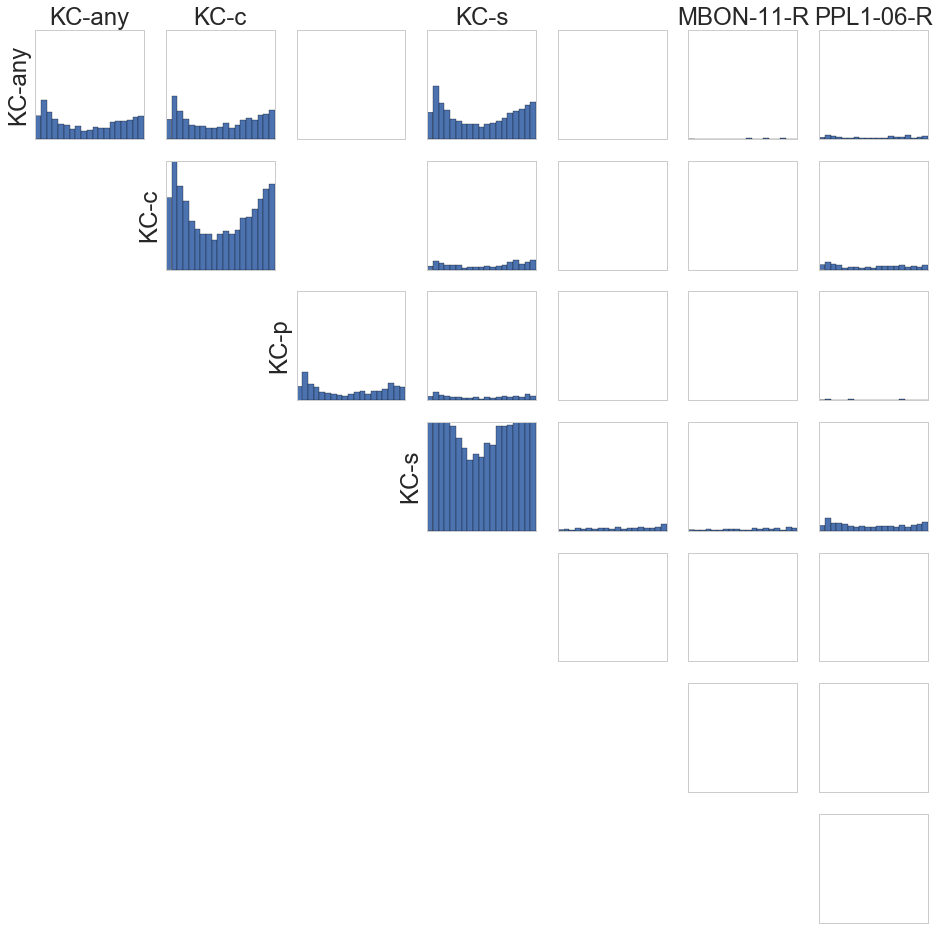

In [1010]:
#### 
from sklearn.neighbors import KernelDensity

tgt_mbon_id = 10563
mbon_pre_dists = a[a['body ID_post'] == tgt_mbon_id]

biggest_cell_types = mbon_pre_dists.cell_type_1.value_counts()[:8].index.values.tolist()
biggest_cell_types.remove("")
order = np.sort(tgt_dists.cell_type_1.value_counts().index.values)

tgt_dists = mbon_pre_dists[(mbon_pre_dists.cell_type_1.isin(biggest_cell_types) & mbon_pre_dists.cell_type_2.isin(biggest_cell_types))]

# now we par them down 
import matplotlib.gridspec as gridspec


fig = pylab.figure(figsize=(16, 16))

gs = gridspec.GridSpec(len(order), len(order))
pos_lut = {k : v for v, k in enumerate(order)}
bins=np.linspace(0, 80, 20)
for (gi, gf), g in tgt_dists.groupby(['cell_type_1', 'cell_type_2']):
    ax = plt.subplot(gs[pos_lut[gi], pos_lut[gf]])

    if len(g.post_dist) > 100:
       
        #sns.distplot(g.post_dist, bins=bins, kde=False, norm_hist=False)
        pylab.hist(g.post_dist, bins=bins)
        #kde = scipy.stats.gaussian_kde(g.post_dist)

        
        #ax.plot(bins, kde(bins)*100000)
        ax.set_ylim(0,700)

        if pos_lut[gf] == pos_lut[gi]:
            ax.set_ylabel(order[pos_lut[gi]], fontsize=24)
        if pos_lut[gi] == 0:
            ax.set_title(order[pos_lut[gf]], fontsize=24)
        #print pos_lut[gi], pos_lut[gf]
    ax.set_xticks([])
    ax.set_yticks([])    

In [1011]:
kc_ids = np.sort(neuronsdf[neuronsdf.name_clean.str.contains('KC-')].index.values)
N = len(kc_ids)
conductivity = np.zeros((N, N))
k_pos = {k: v for v, k in enumerate(kc_ids)}
a = df[df['body ID_post'] == tgt_mbon_id]
print len(a)
for c_i, c in a.iterrows():
    if (c['body ID_1'] in k_pos) and (c['body ID_2'] in k_pos):
        i, j =  k_pos[c['body ID_1']], k_pos[c['body ID_2']]
        conductivity[i, j] += 1./(c.post_dist + 10)


133482


In [1012]:
s = neuronsdf.ix[kc_ids].name_clean
ai = np.argsort(s)

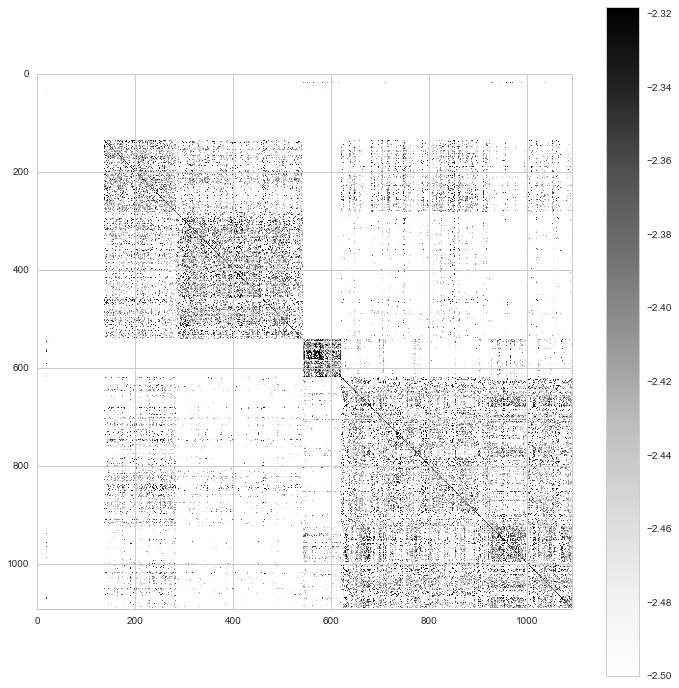

In [1013]:
c = conductivity[ai]
c = c[:, ai]

pylab.figure(figsize=(12, 12))
pylab.imshow(np.log10(c), vmax=-2.5)  # , cmap=pylab.cm.jet)
pylab.colorbar()

In [1014]:
#for all synapses sites on a mbon, how does rosette size vary with threshold:
    

In [1015]:
# ok just for each MBON compute the distances between synapses using the 
#  identified by tbar ID

#warning takes a long time
rosette_res = []
all_rosette_all_dist = []
MAX_DIST = 140
for thold in [10, 20, 30, 40, 50, 60]:
    for mbon_body_id, mbons_post in dfmerged_mbon_post.groupby('body ID_post'):
        print "solving for MBON id=", mbon_body_id, len(mbons_post), "connections"
        # post-synaptic distance matrix
        postsyn_vector = np.zeros((len(mbons_post), 3))
        postsyn_vector[:, 0] = mbons_post.loc_x_post
        postsyn_vector[:, 1] = mbons_post.loc_y_post
        postsyn_vector[:, 2] = mbons_post.loc_z_post

        post_dists = sklearn.metrics.pairwise.euclidean_distances(postsyn_vector)

        ng = sklearn.neighbors.radius_neighbors_graph(postsyn_vector,
                                                      thold, 
                                                      include_self=True)
        cc = scipy.sparse.csgraph.connected_components(ng)[1]

        m = mbons_post.copy()
        m['rosette'] = cc
        m['rosette_id'] = m.apply(lambda x: "{}:{}".format(mbon_body_id, x.rosette), axis=1)
        m['rosette_thold'] = thold
        all_rosette_all_dist.append(m)
        

solving for MBON id= 10563 14509 connections
solving for MBON id= 54977 14252 connections
solving for MBON id= 616459 12499 connections
solving for MBON id= 1190582 718 connections
solving for MBON id= 1661302 1556 connections
solving for MBON id= 2089450 138 connections
solving for MBON id= 3338684 11180 connections
solving for MBON id= 3391197 4056 connections
solving for MBON id= 3878341 11394 connections
solving for MBON id= 4834094 92 connections
solving for MBON id= 5189028 161 connections
solving for MBON id= 8101328 787 connections
solving for MBON id= 8862577 25 connections
solving for MBON id= 149383611 1070 connections
solving for MBON id= 10563 14509 connections
solving for MBON id= 54977 14252 connections
solving for MBON id= 616459 12499 connections
solving for MBON id= 1190582 718 connections
solving for MBON id= 1661302 1556 connections
solving for MBON id= 2089450 138 connections
solving for MBON id= 3338684 11180 connections
solving for MBON id= 3391197 4056 connectio

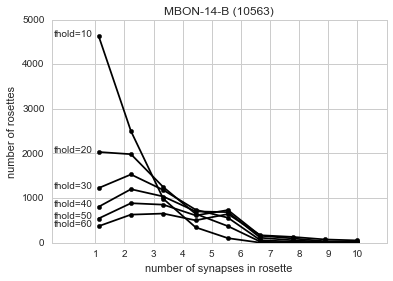

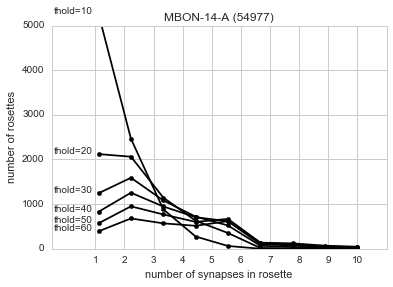

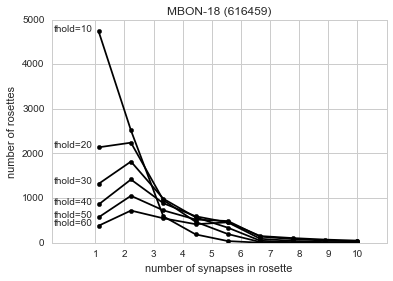

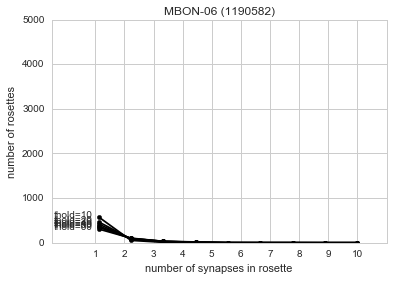

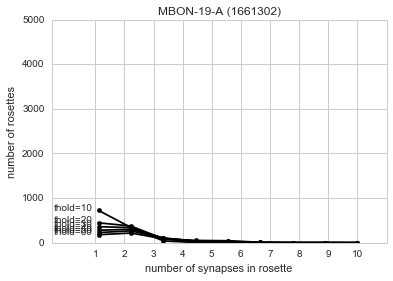

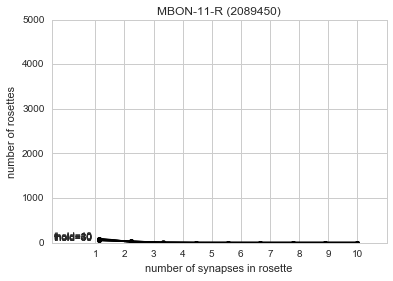

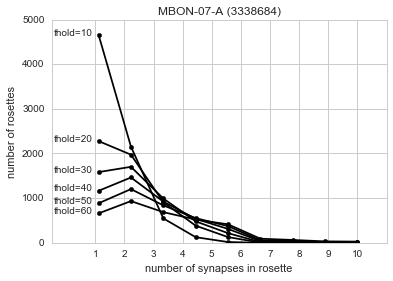

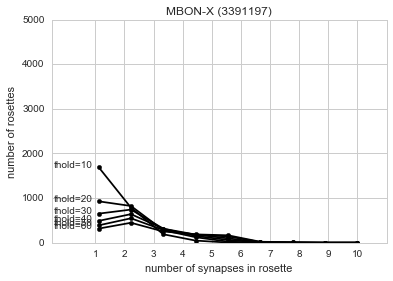

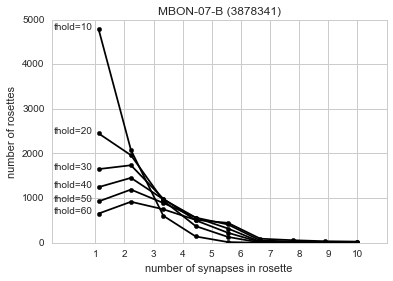

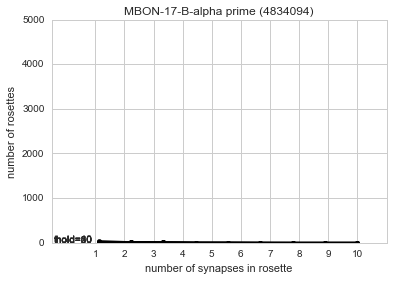

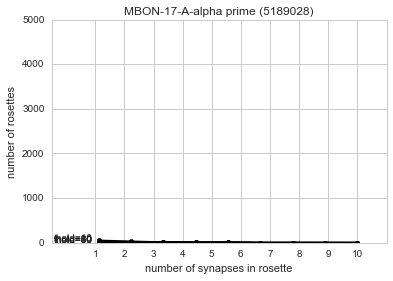

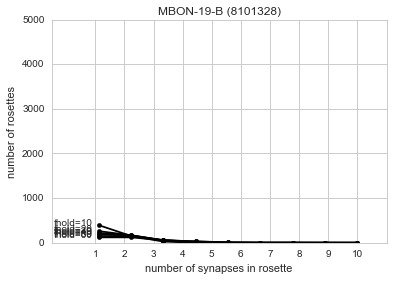

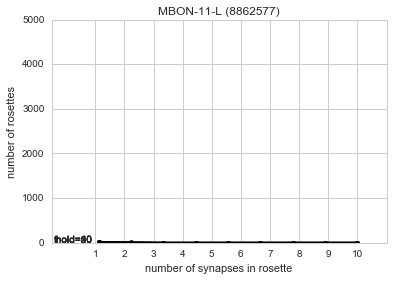

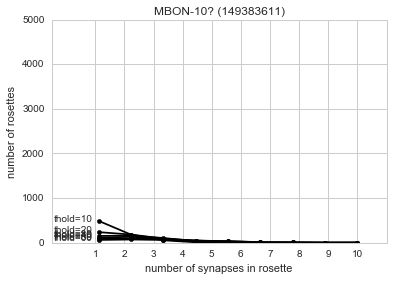

In [1031]:
bins = np.linspace(0, 10, 10) + 0.5
all_rosette_df = pd.concat(all_rosette_all_dist)
for mbon_id, mbon_rosettes in all_rosette_df.groupby('body ID_post'):
    fig = pylab.figure()
    ax = fig.add_subplot(1, 1, 1)
    for thold, atthold in mbon_rosettes.groupby('rosette_thold'):
        h, _ = np.histogram(atthold.rosette_id.value_counts(), bins)
        
        ax.plot(bins[1:]-0.5, h, c='k')
        ax.scatter(bins[1:]-0.5, h, c='k', edgecolor='k')
        ax.text( 0.9, h[0],"thold={}".format(thold), horizontalalignment='right')
        #ax.plot(bins, kde(bins)*100000)
    ax.set_title("{} ({})".format(neuronsdf.ix[mbon_id].name_clean, mbon_id))
    ax.set_xticks(range(1, 11))
    ax.set_xlim(-0.5, 11)
    ax.set_ylim(0, 5000)
    ax.set_xlabel("number of synapses in rosette")
    ax.set_ylabel("number of rosettes")
    

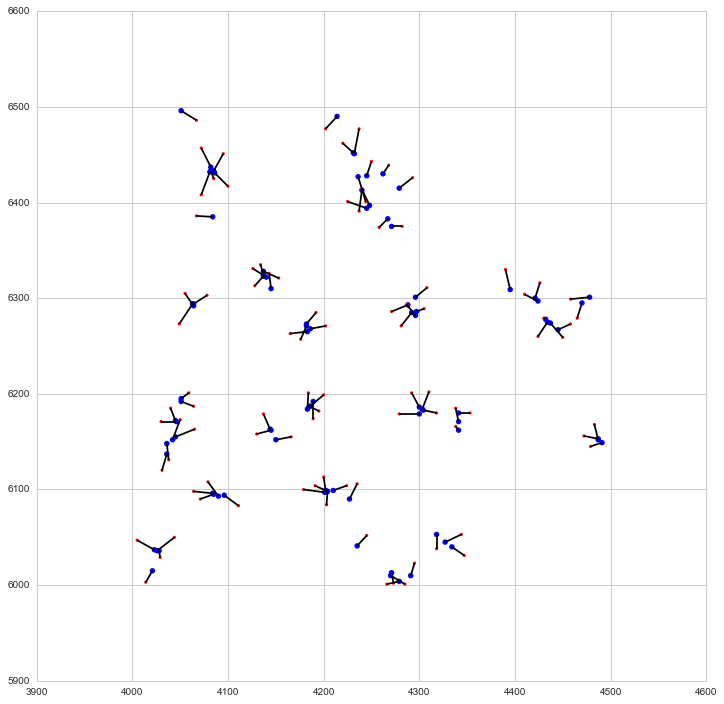

In [1017]:
tgt_id = 10563
a = all_rosette_df[all_rosette_df['body ID_post'] == tgt_id]
thold = 10
b = a[a.rosette_thold == thold]
zdim = 2900, 3100
xdim = 4000, 4500
ydim = 6000, 6500
c = b[(b.loc_x_post > xdim[0]) & (b.loc_x_post < xdim[1]) & \
     (b.loc_y_post > ydim[0]) & (b.loc_y_post < ydim[1]) &\
     (b.loc_z_post > zdim[0]) & (b.loc_z_post < zdim[1])]

fig =pylab.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1,1 )
ax.scatter(c.loc_x_post, c.loc_y_post, edgecolor='none', c='b', s=30, alpha=1)
ax.scatter(c.loc_x_pre, c.loc_y_pre, edgecolor='none', c='r', s=10)
l = []
for ri, r in c.iterrows():
    l.append([(r.loc_x_pre, r.loc_y_pre), (r.loc_x_post, r.loc_y_post)])
lc = LineCollection(l, color='k')
ax.add_collection(lc)


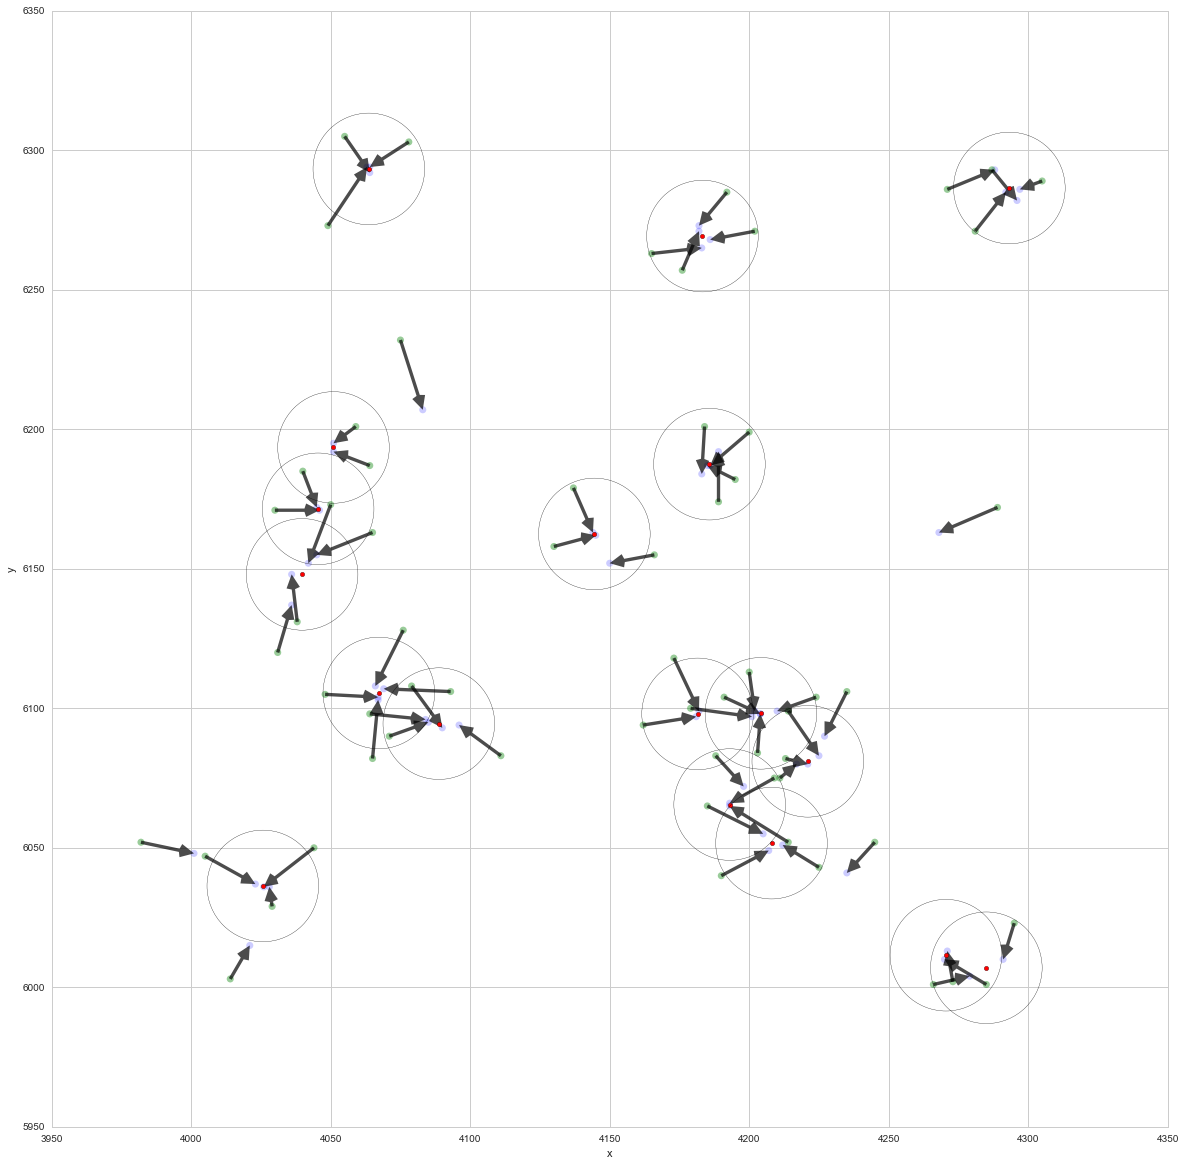

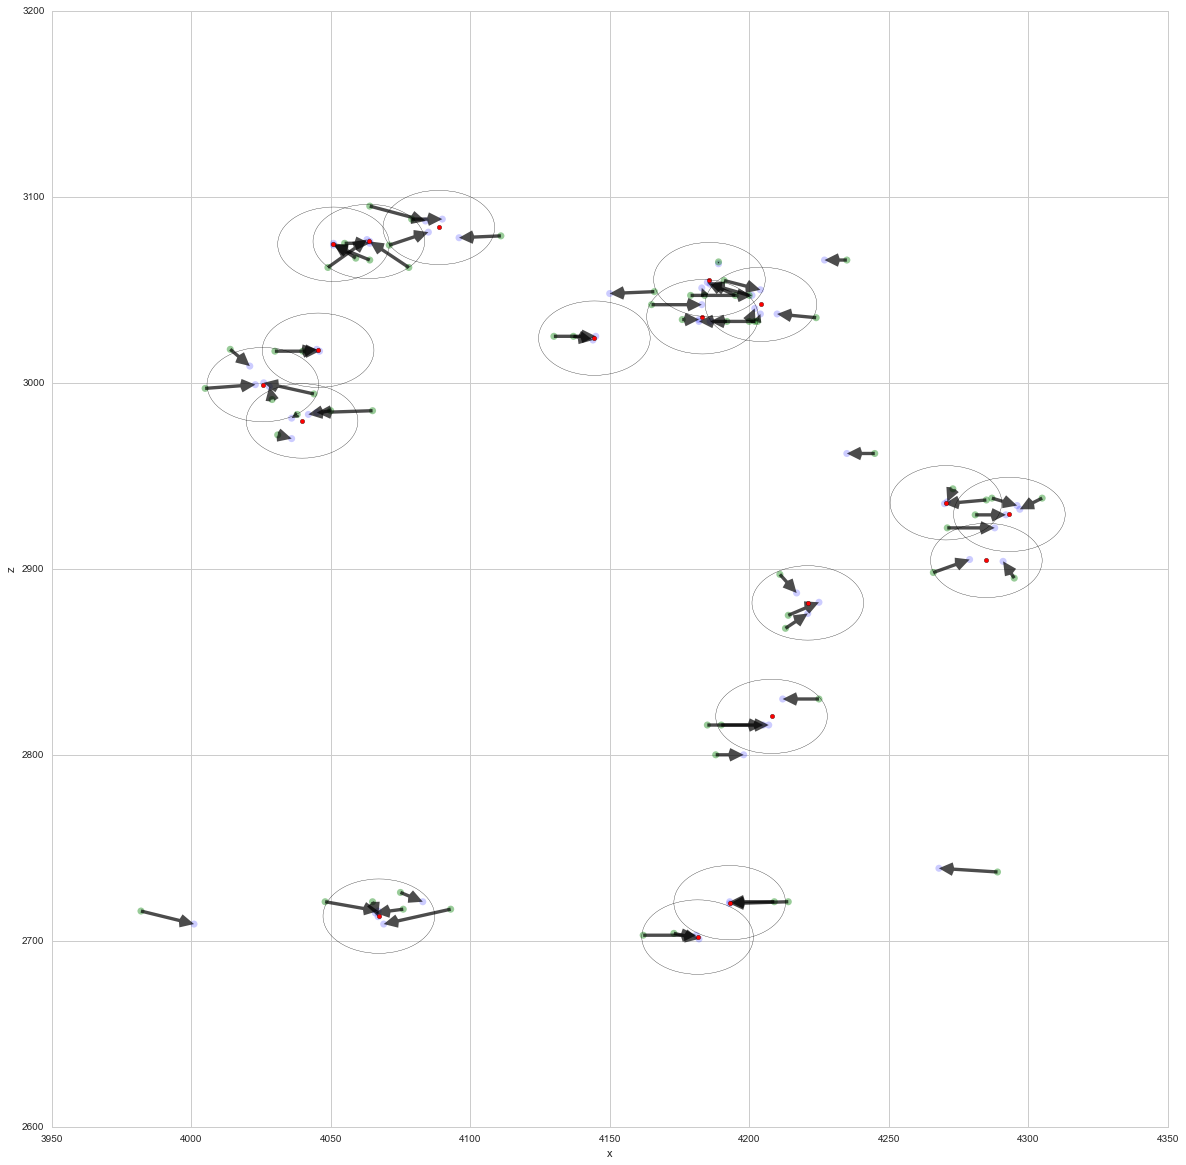

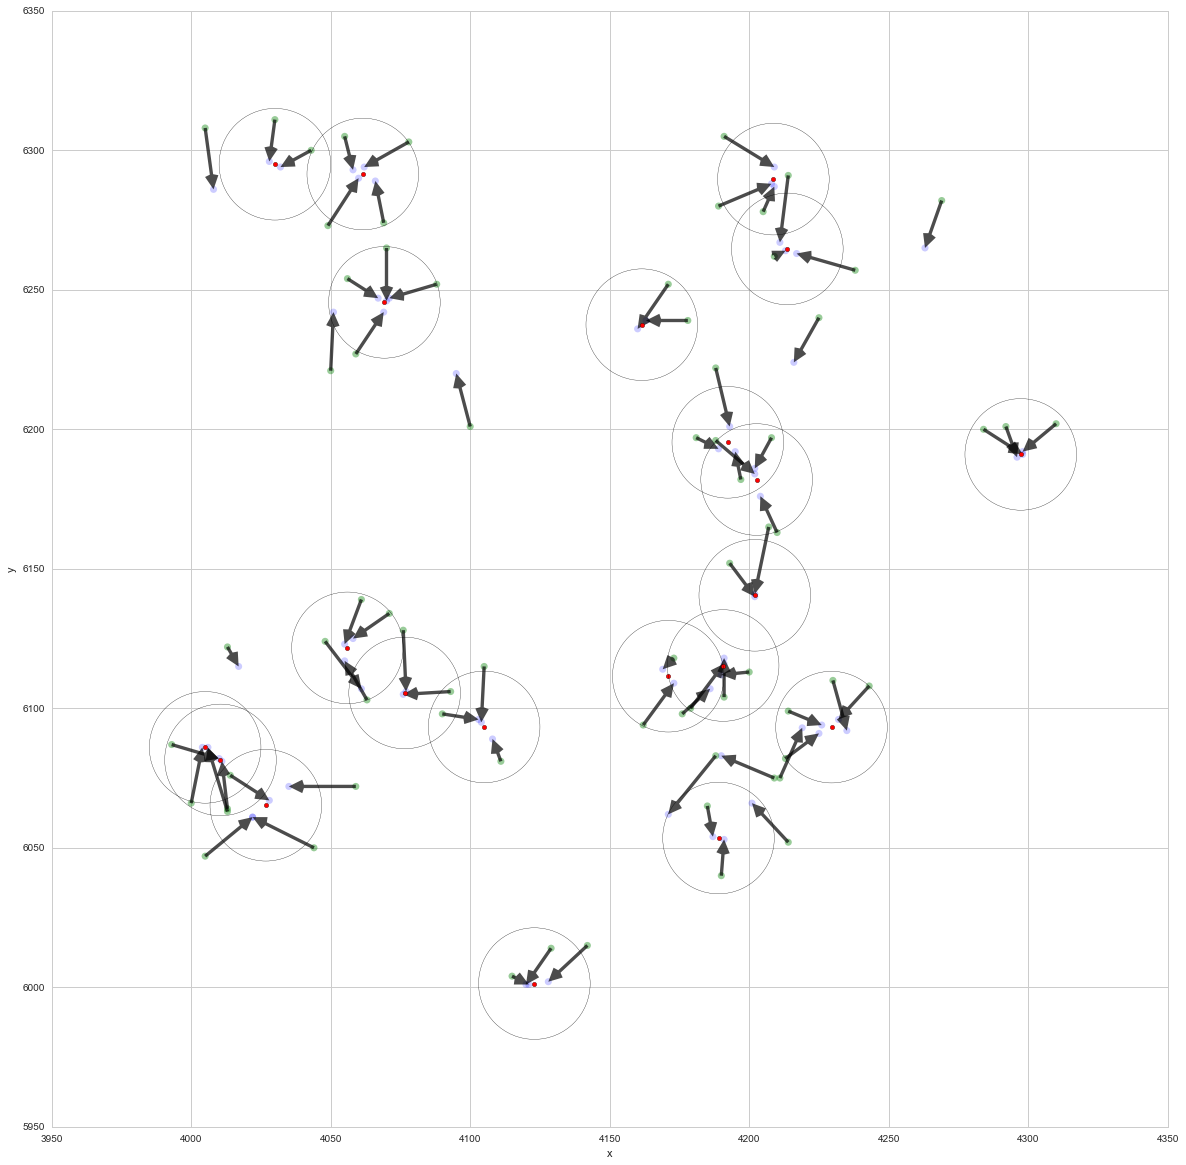

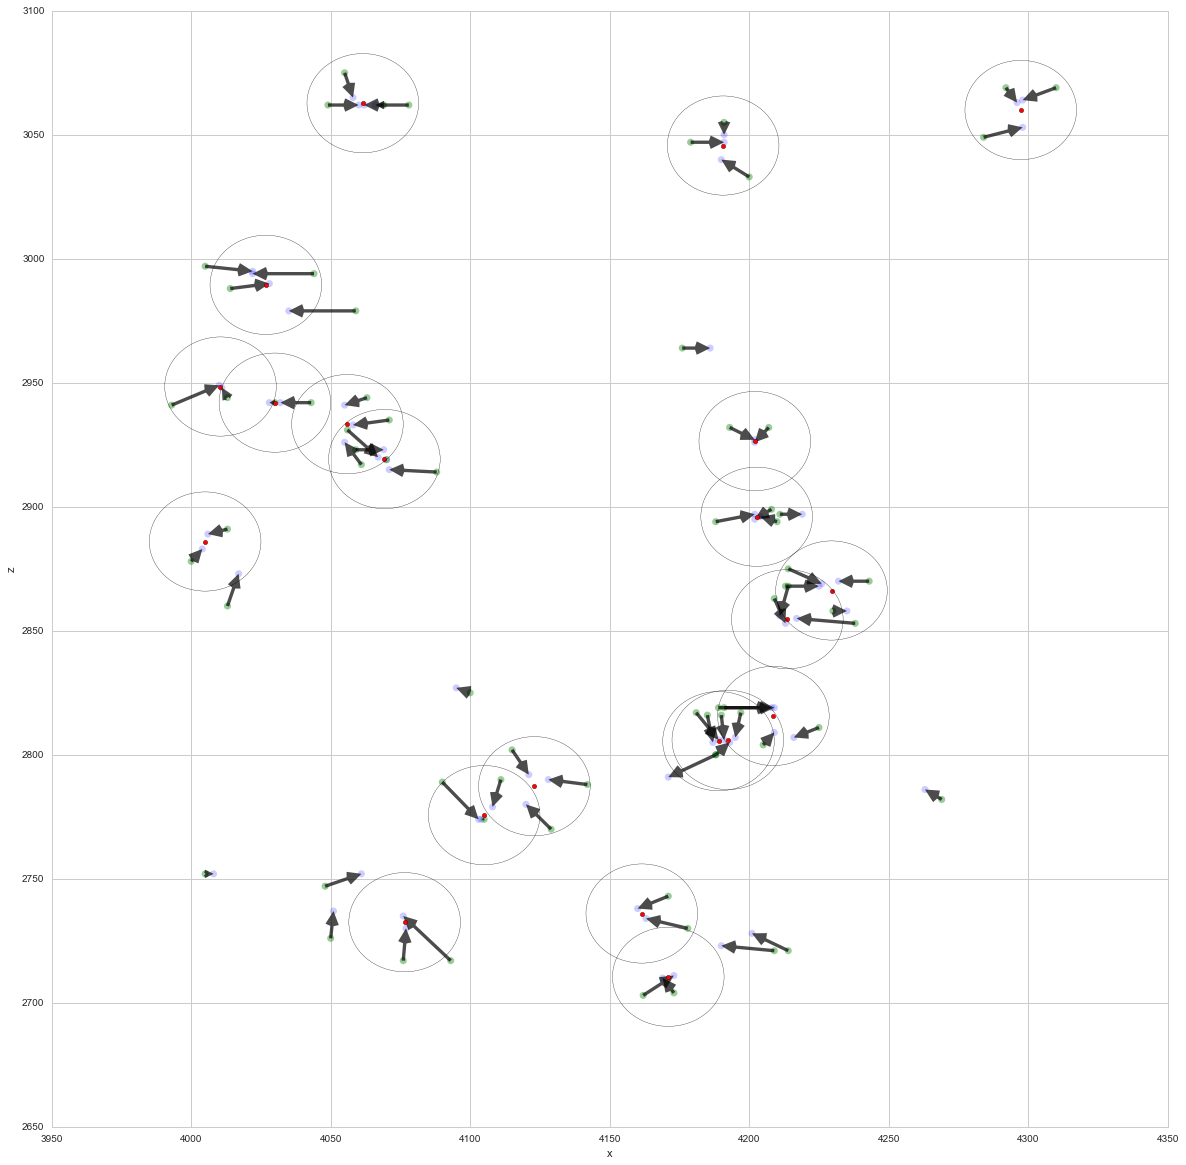

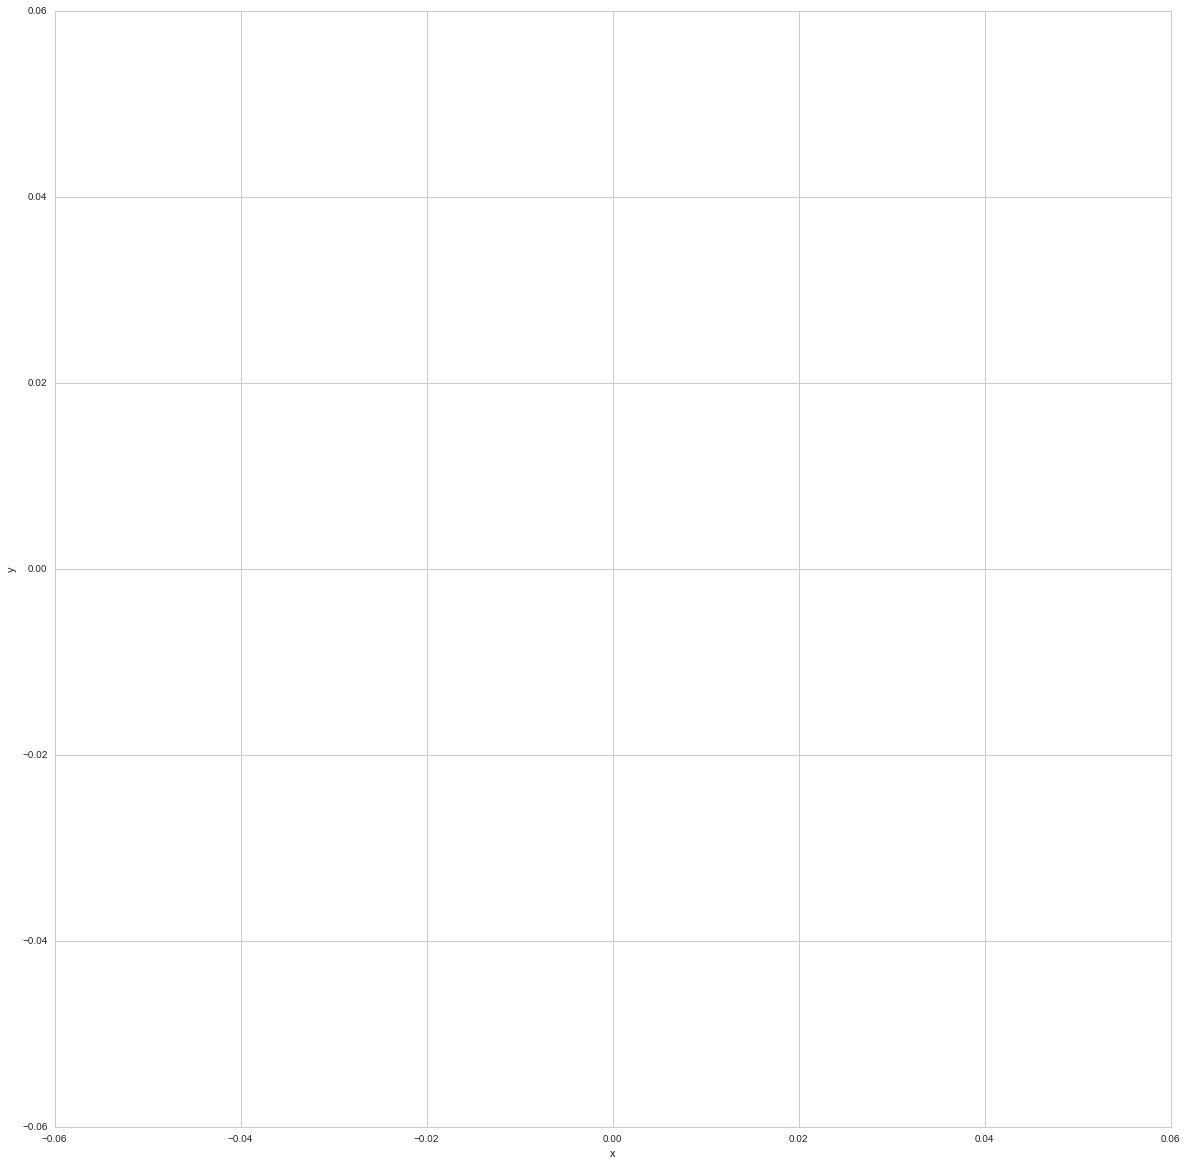

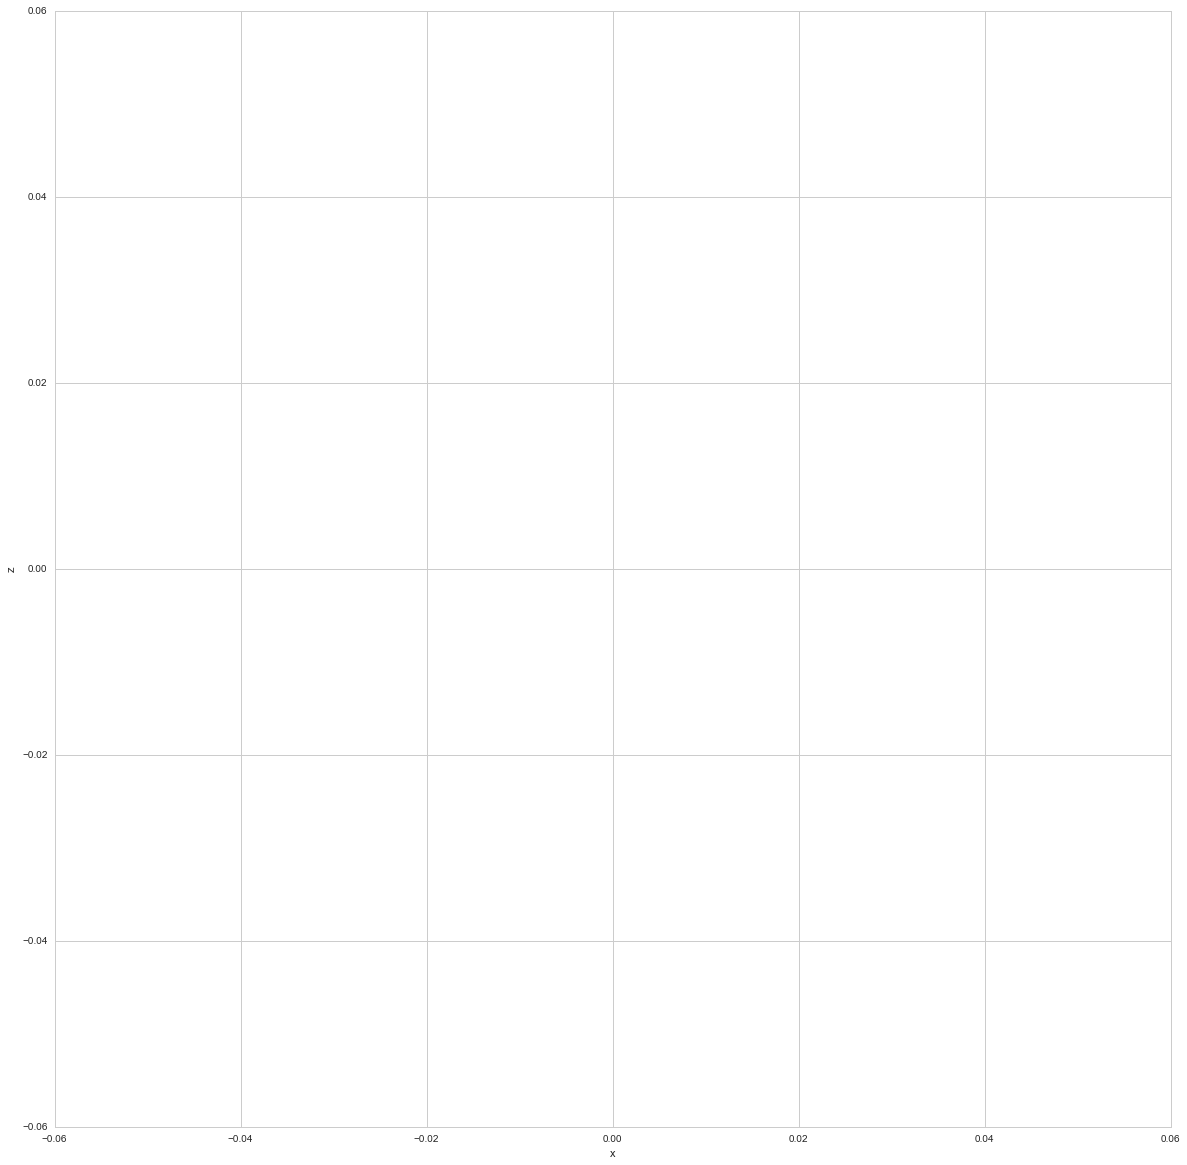

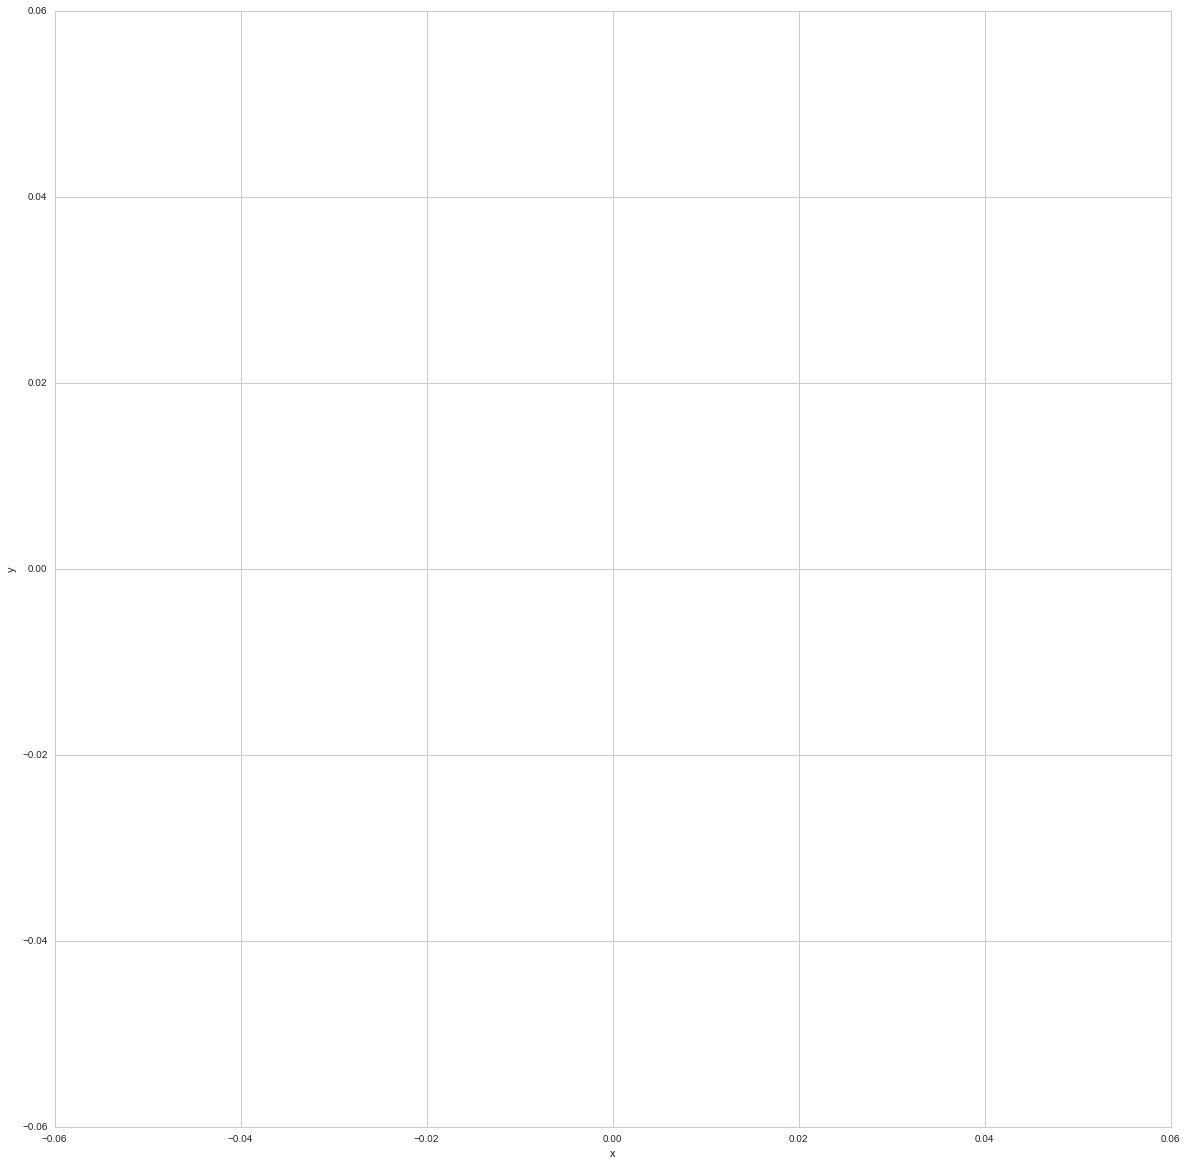

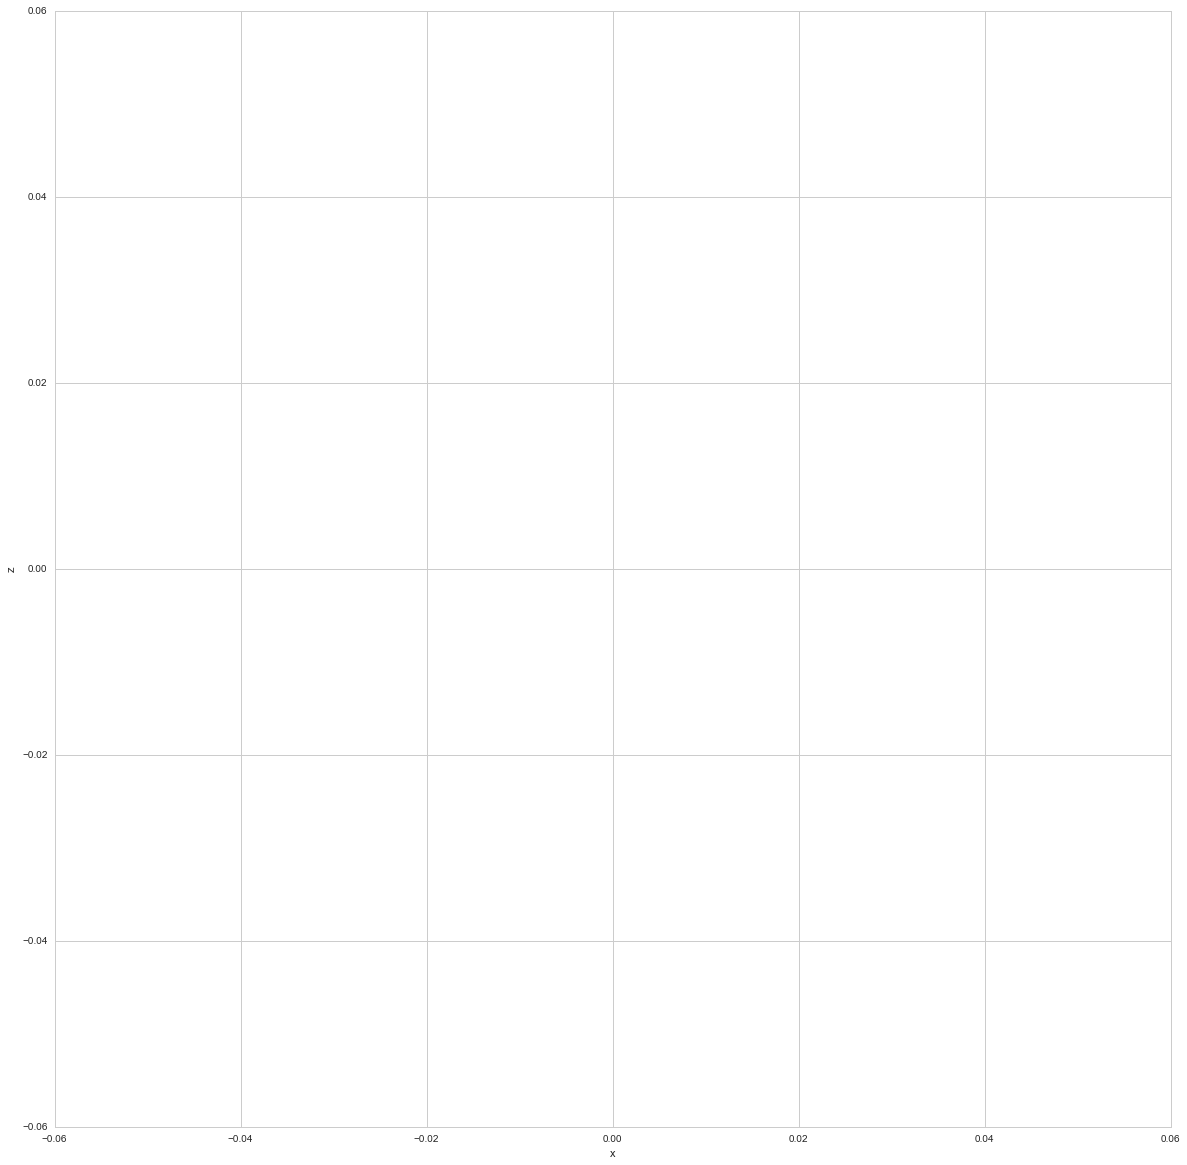

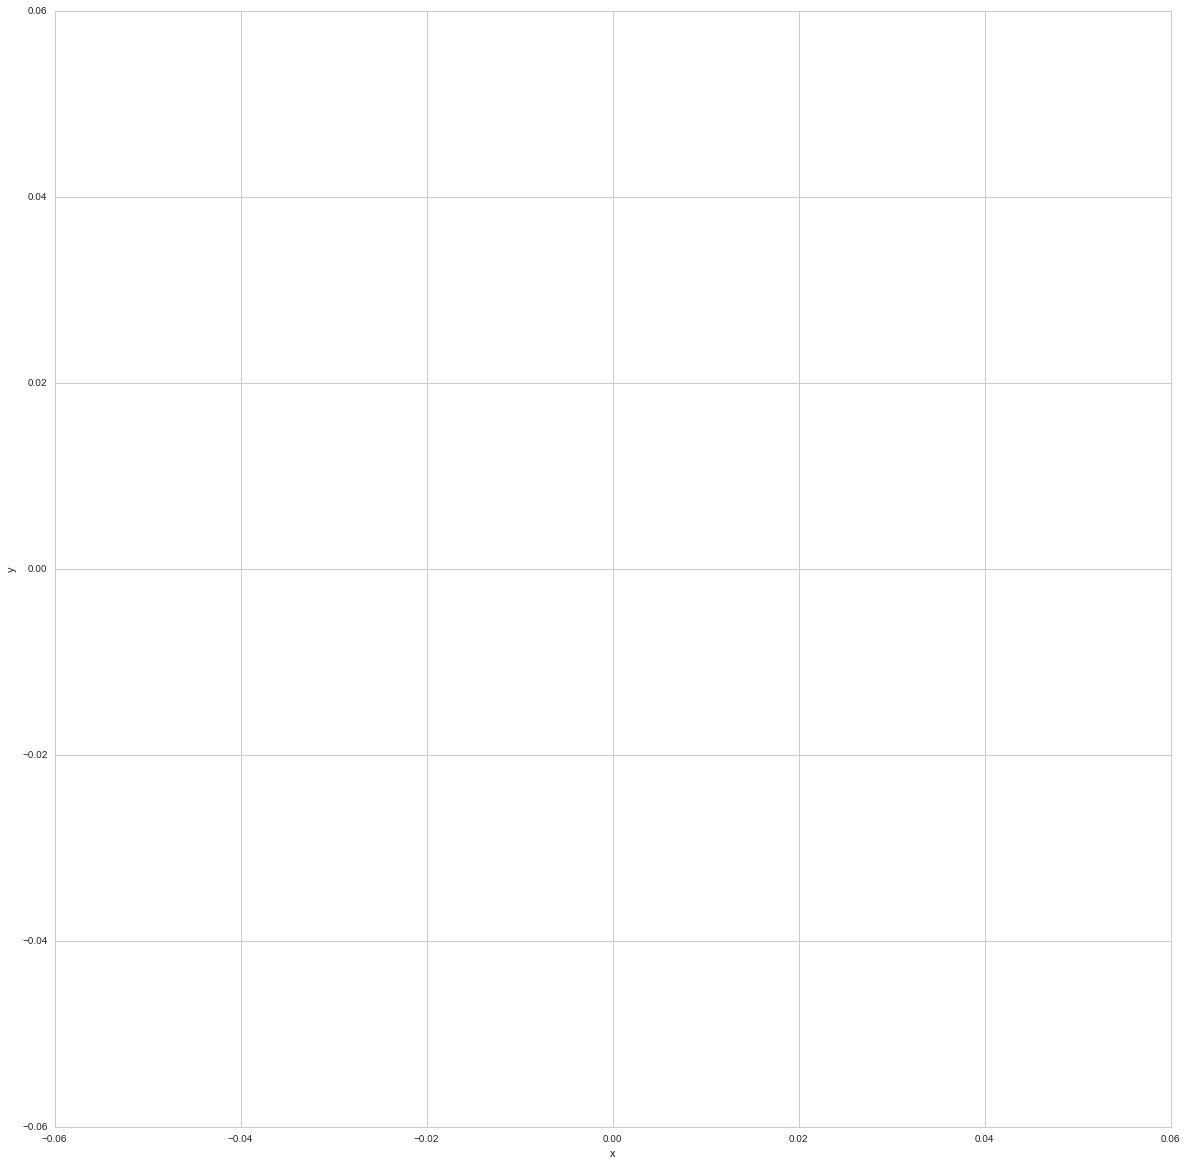

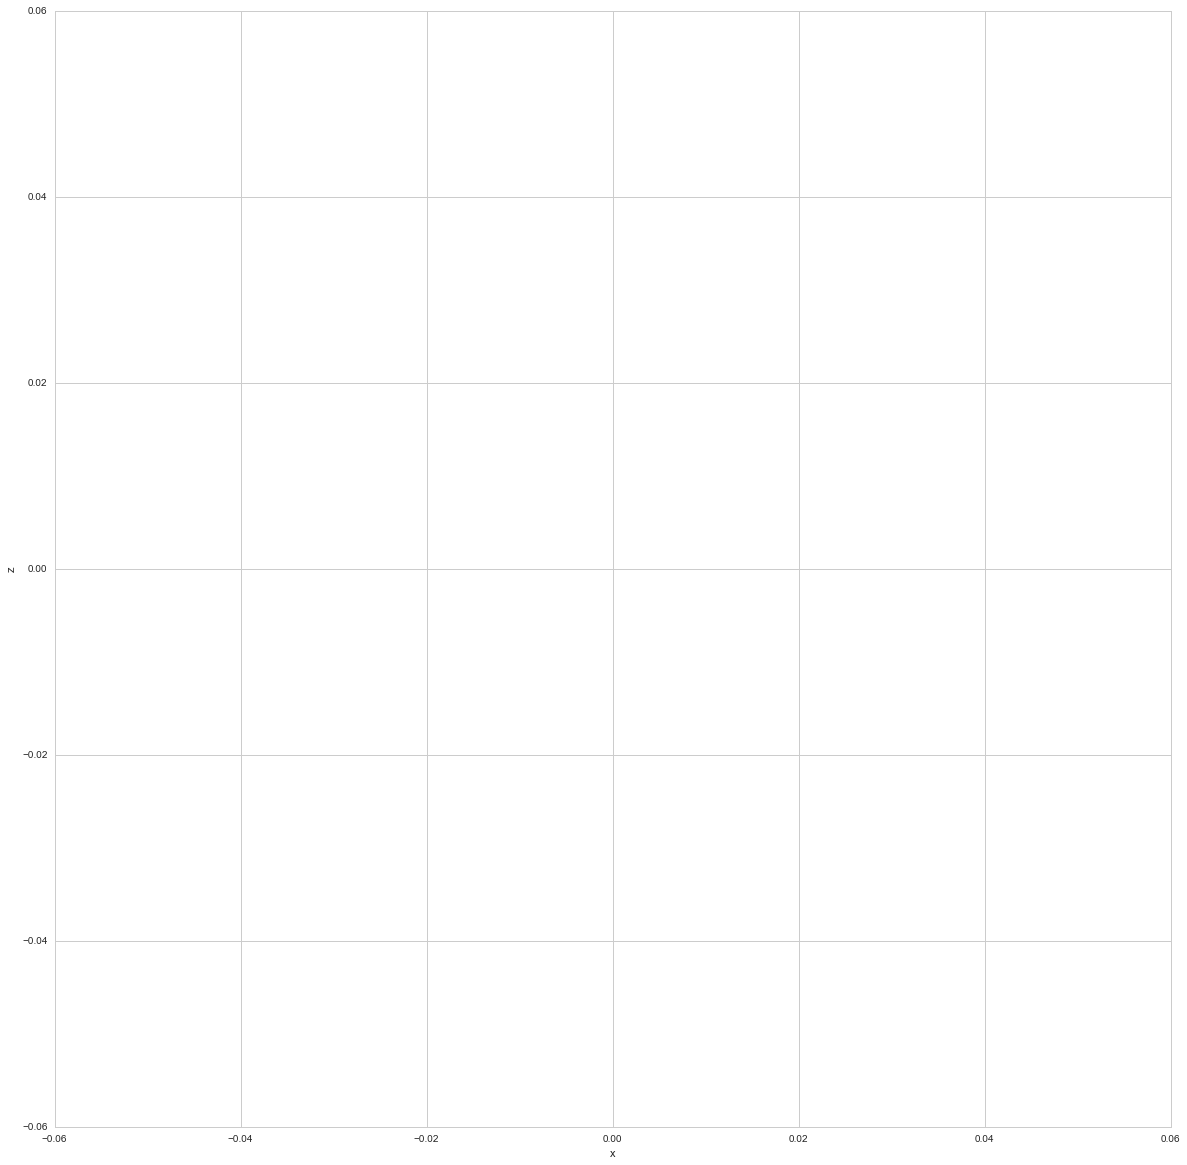

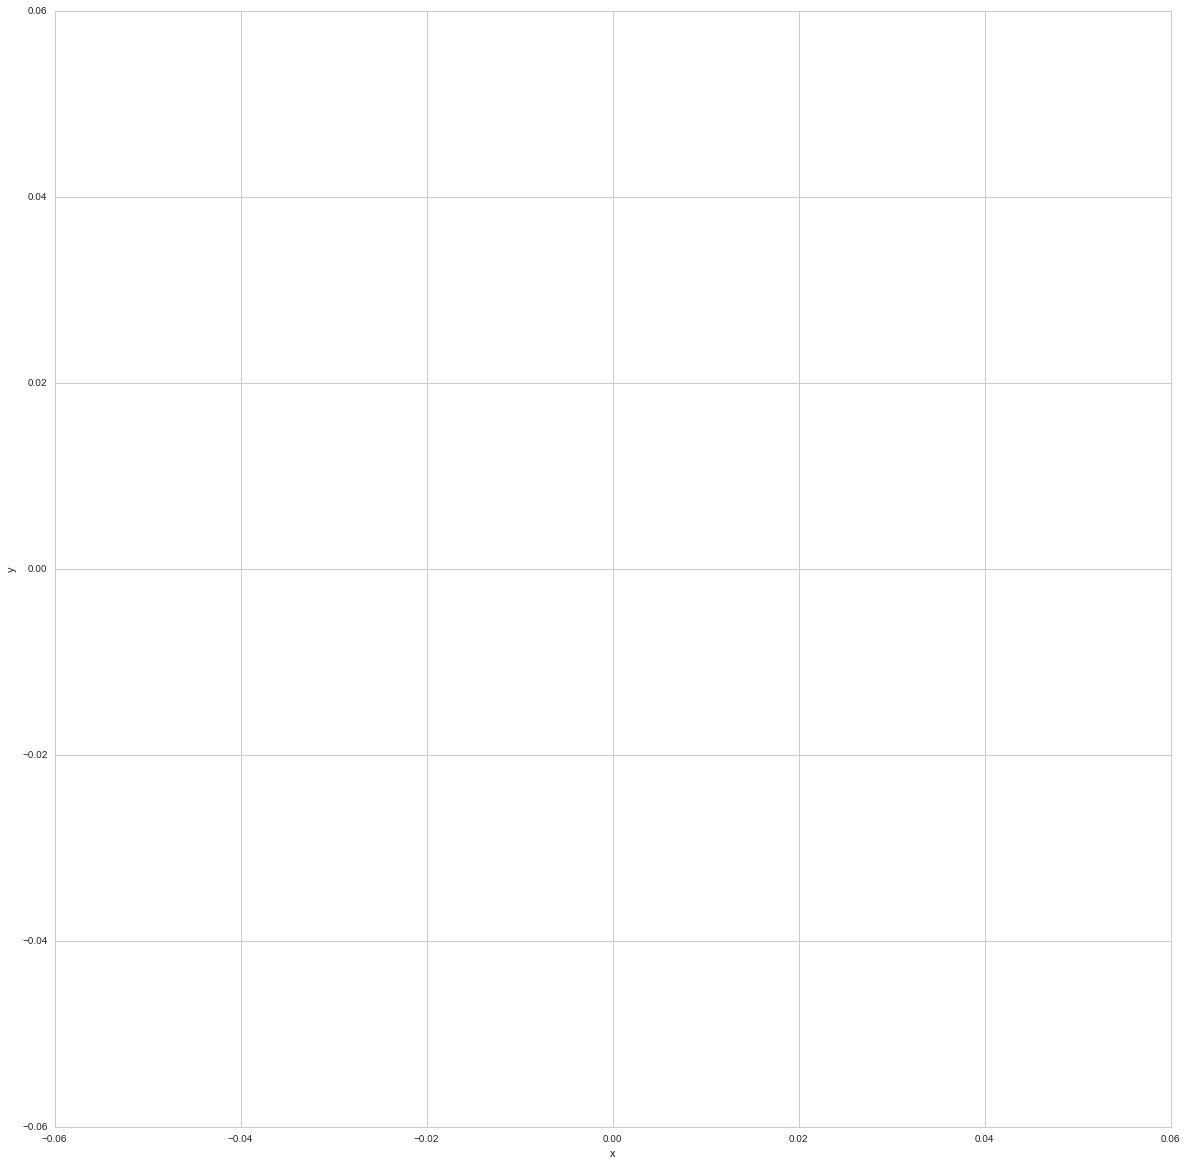

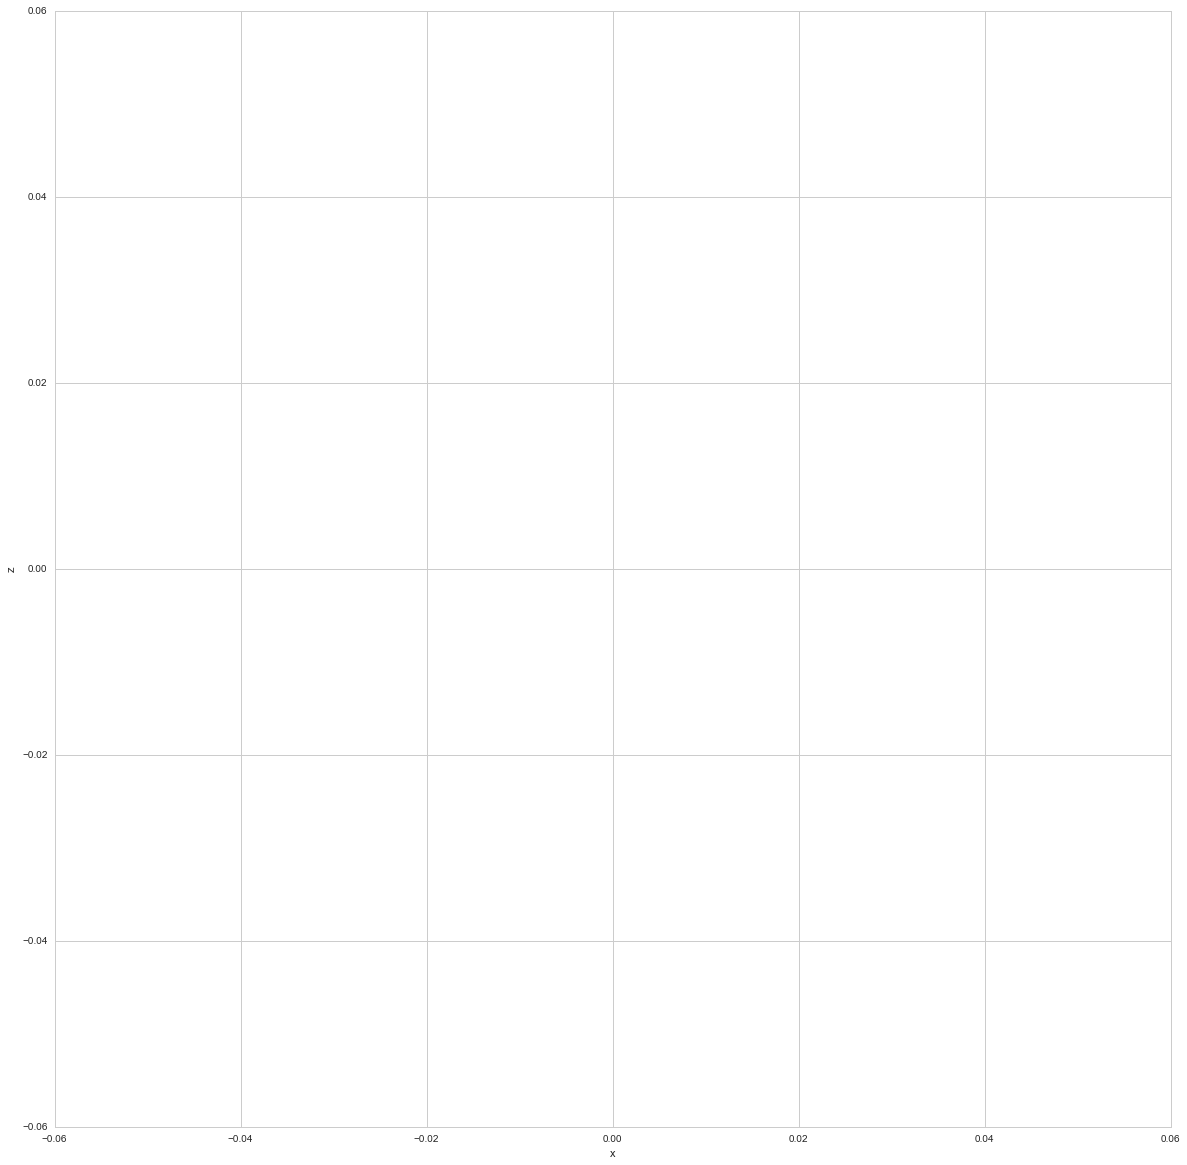

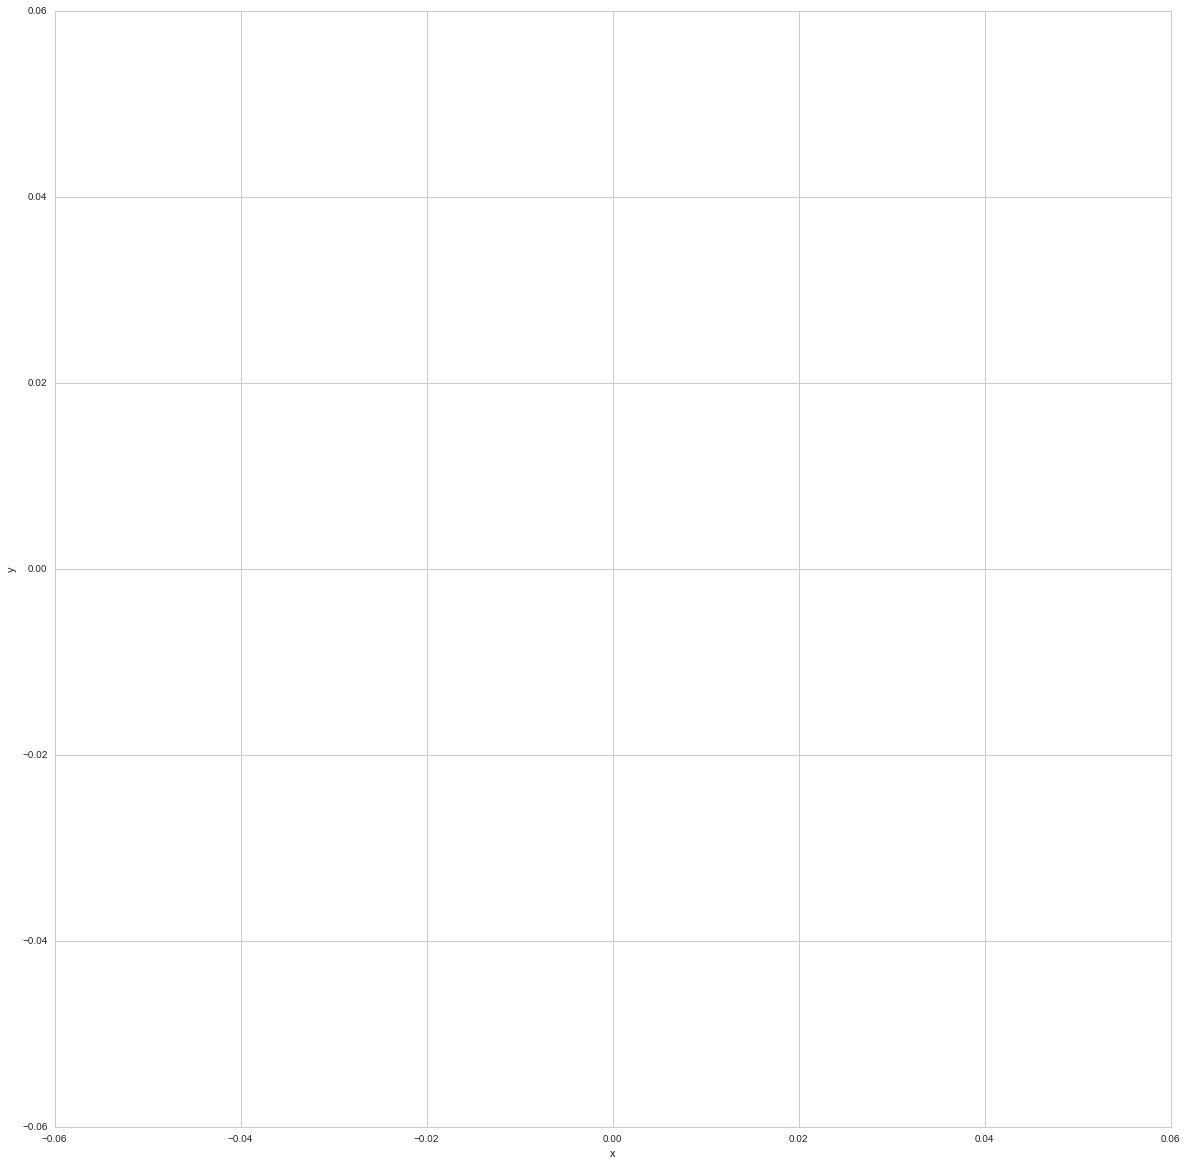

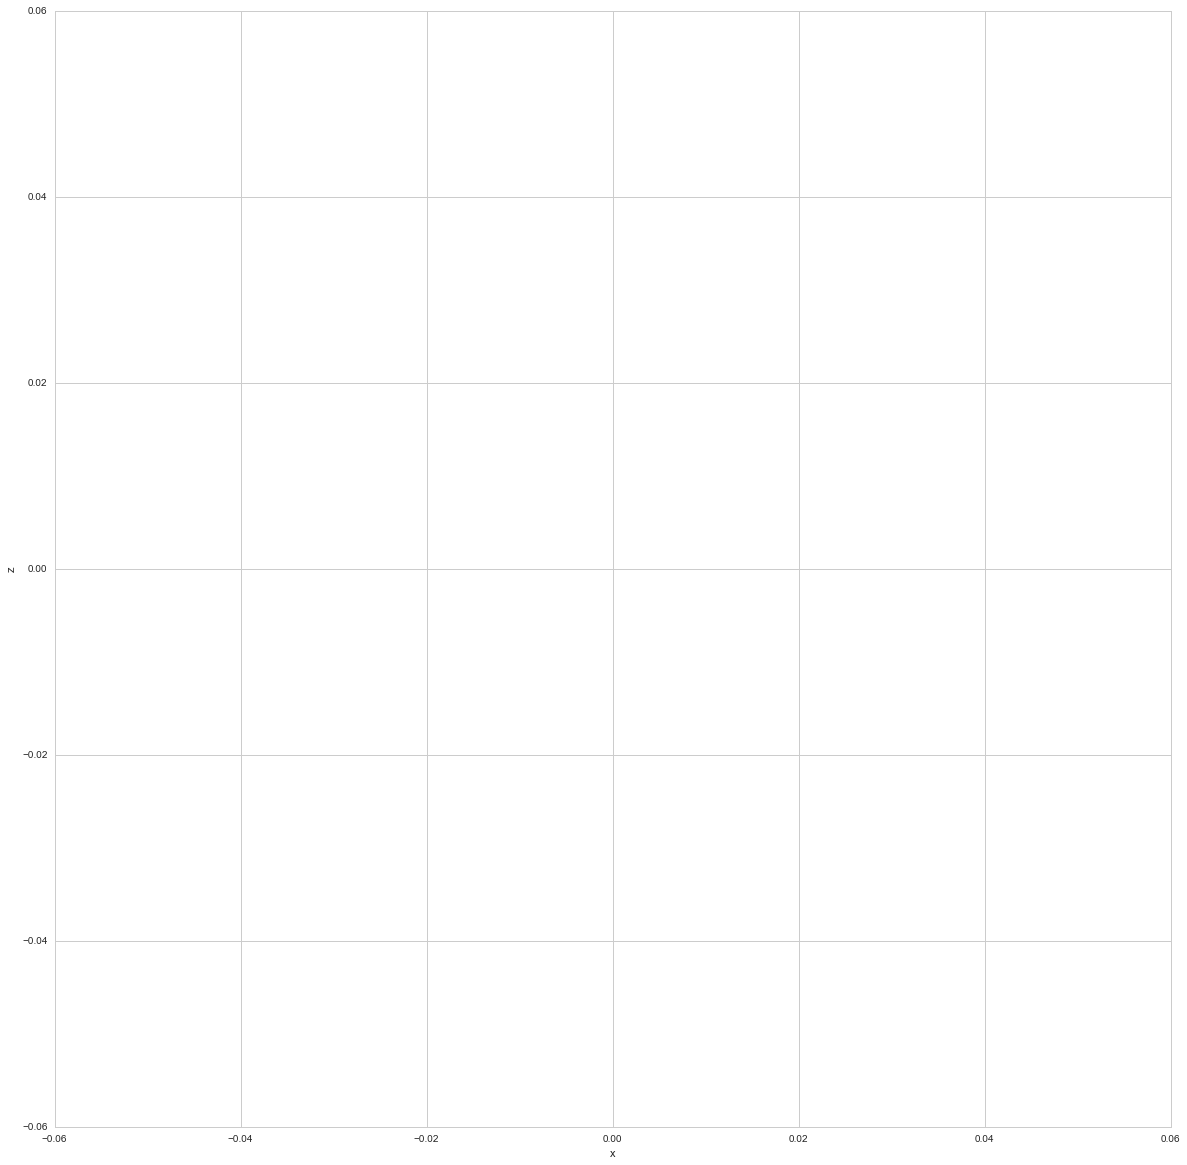

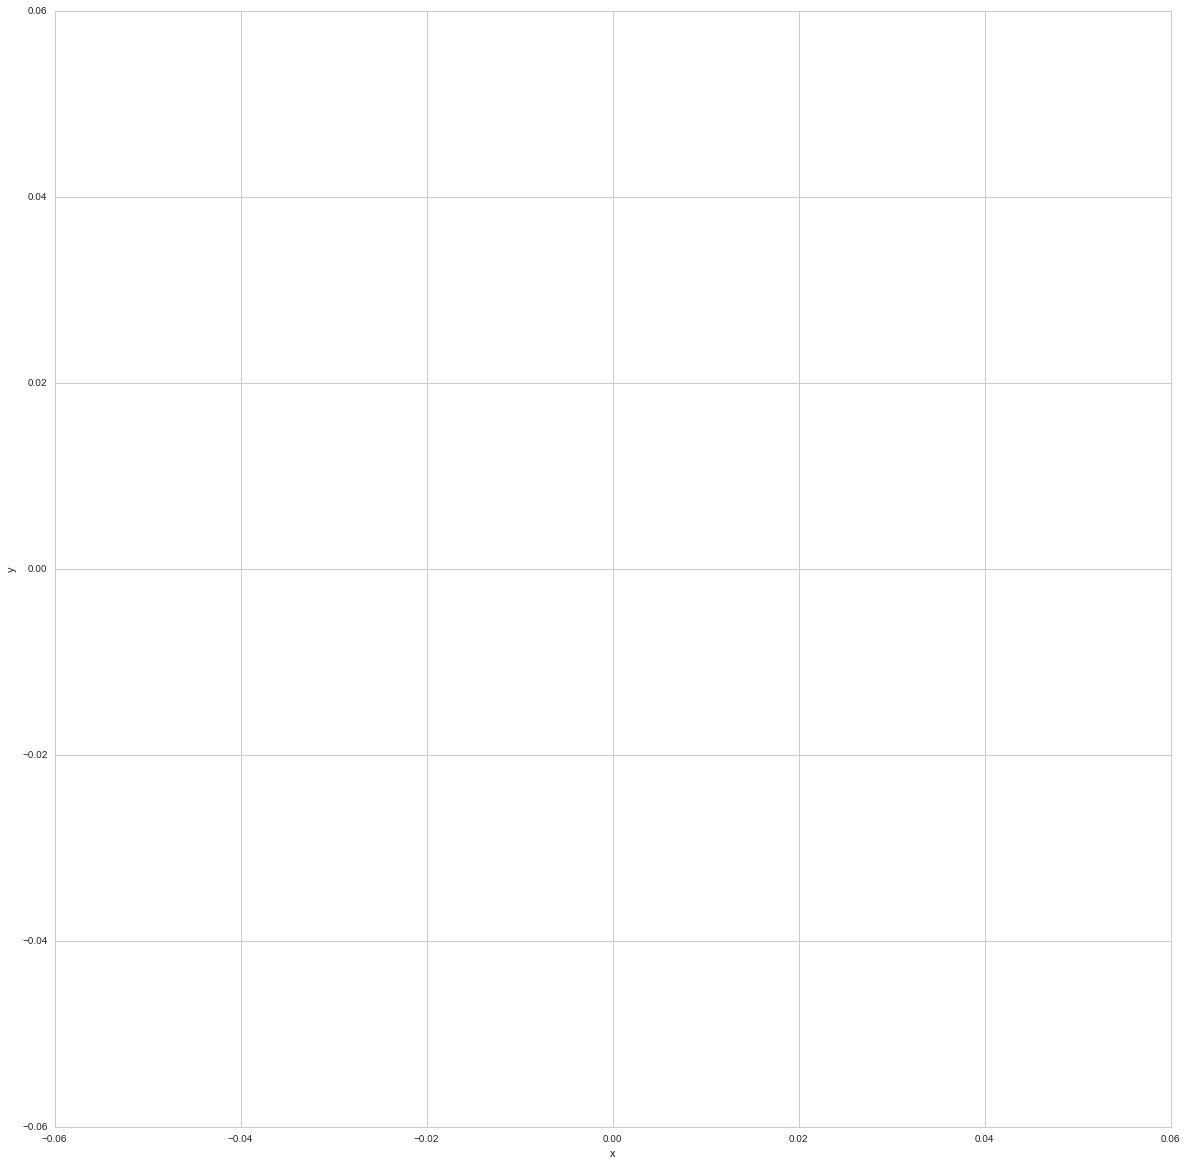

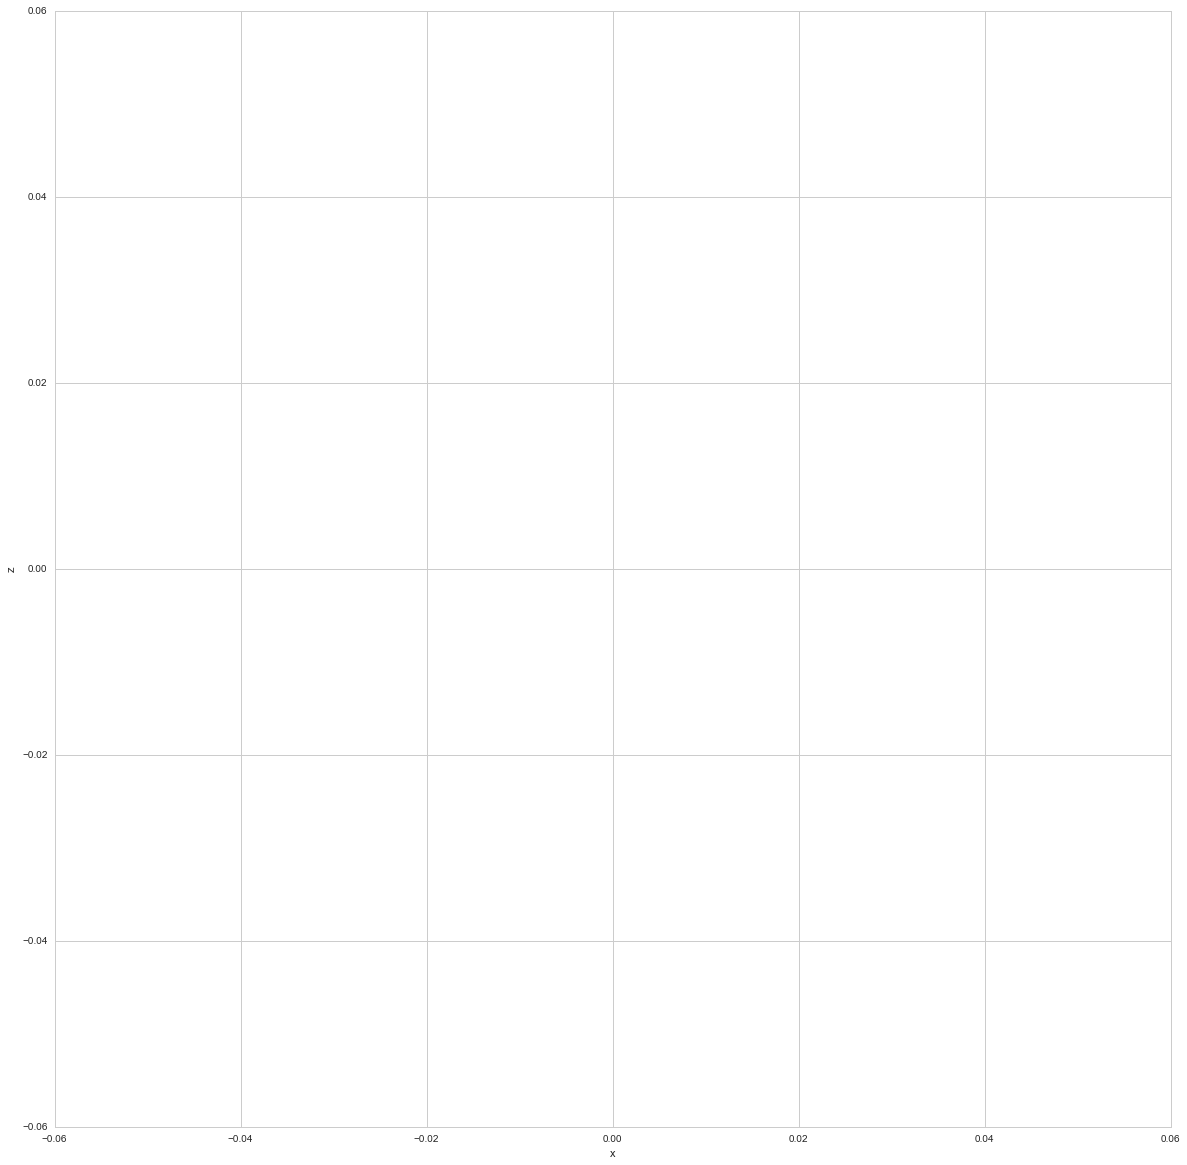

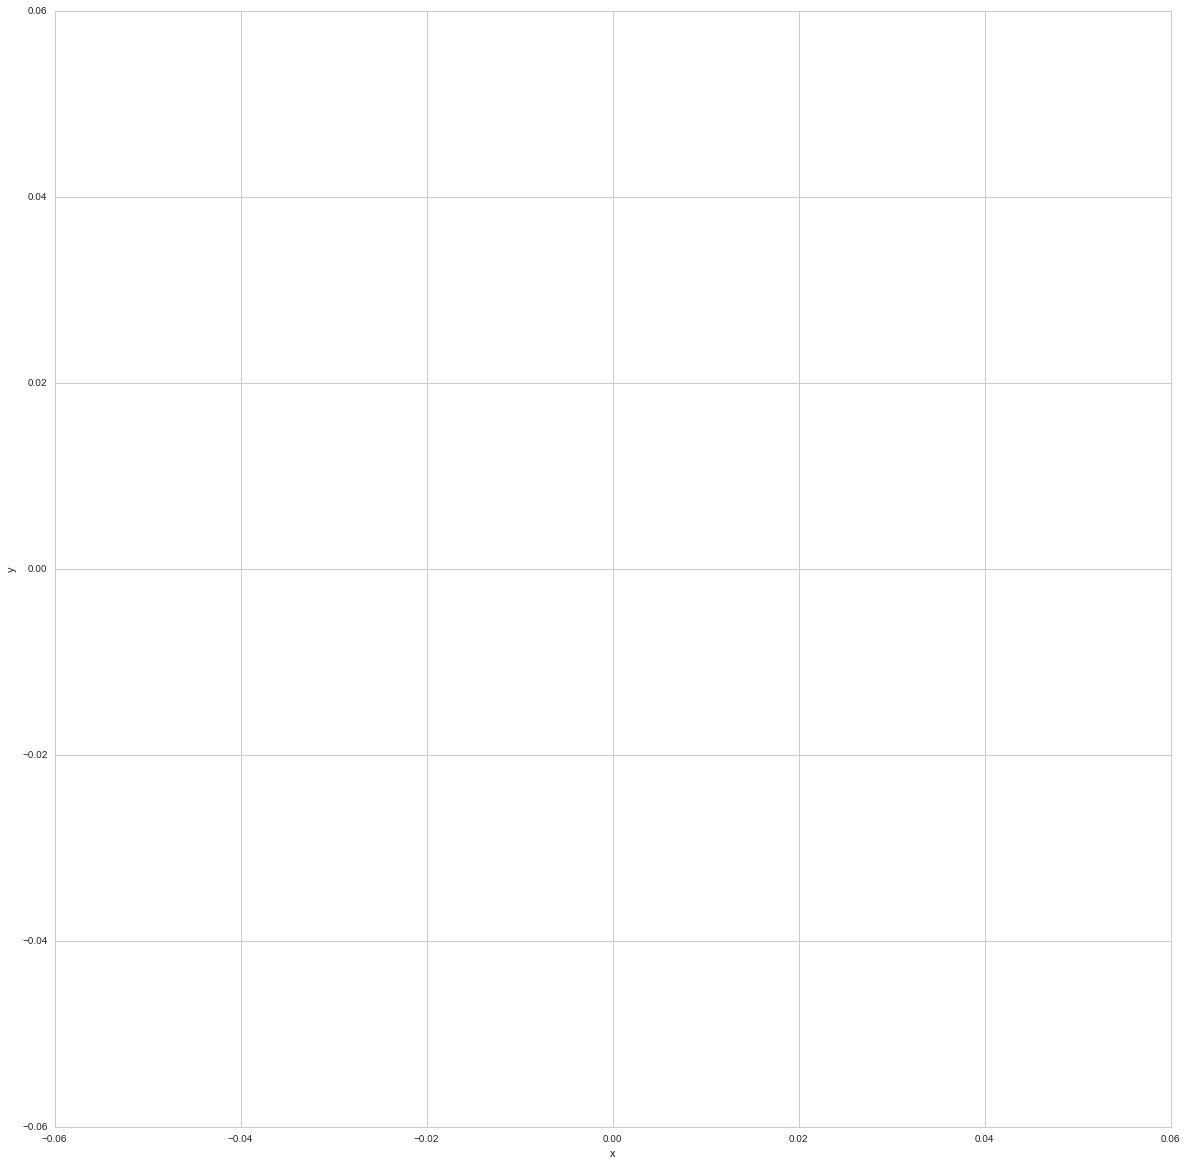

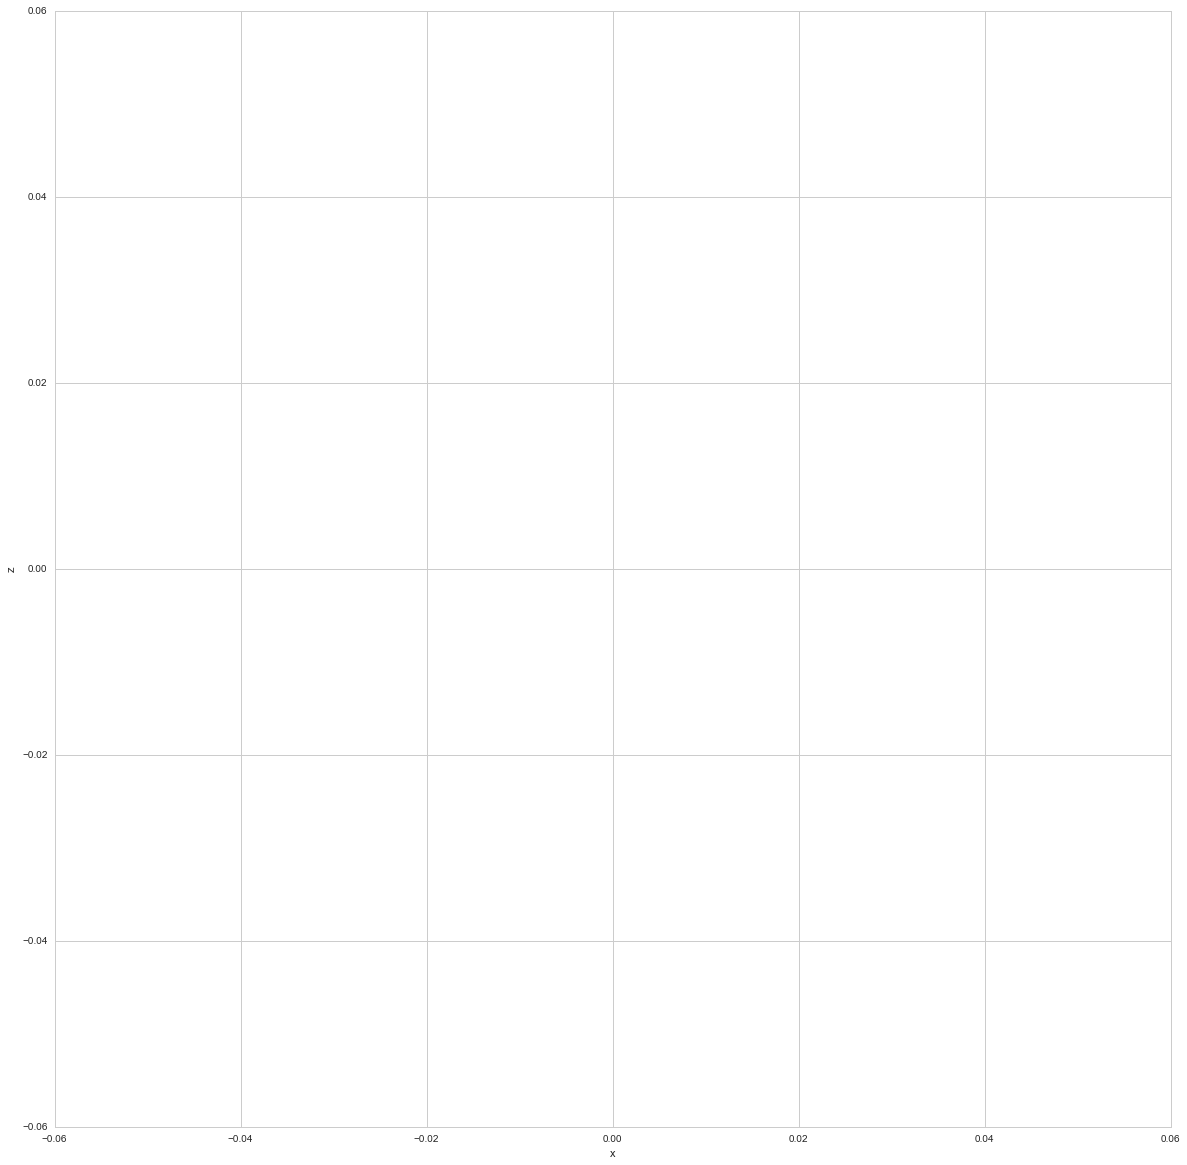

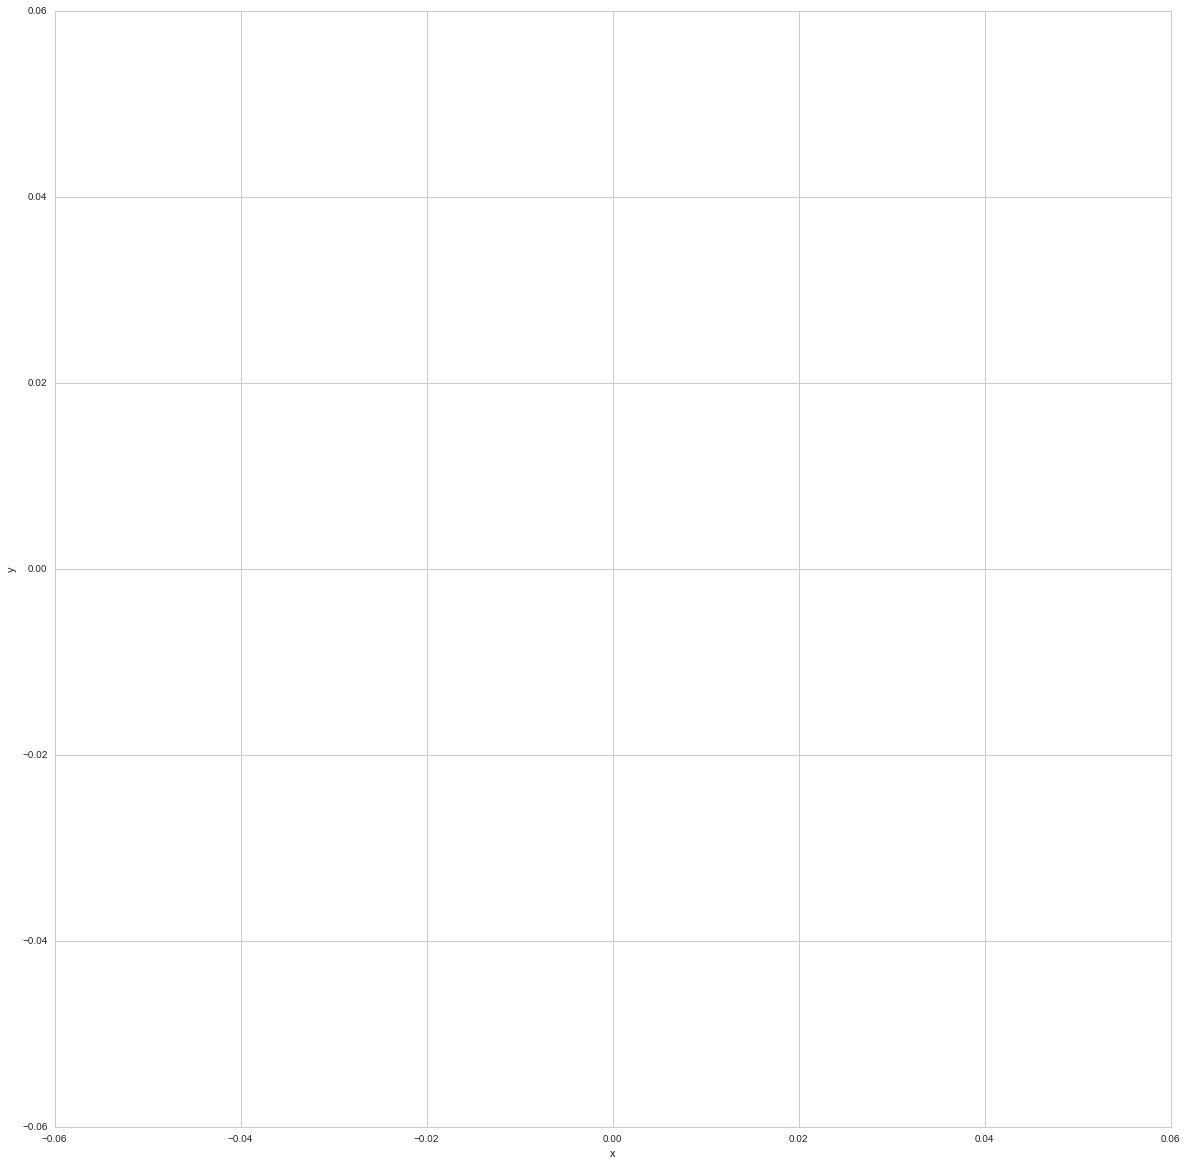

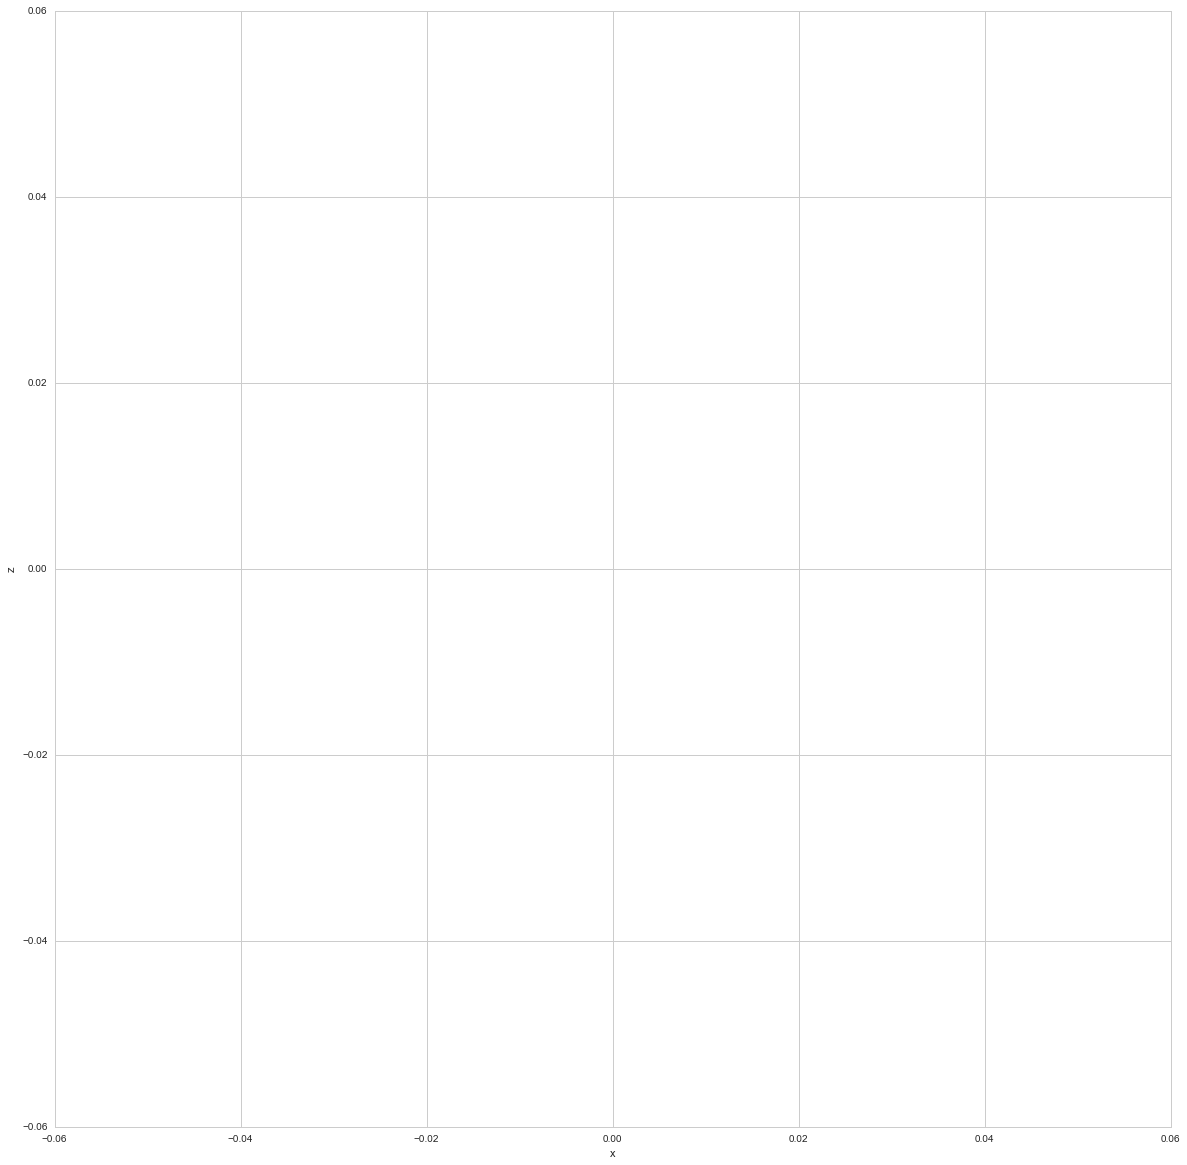

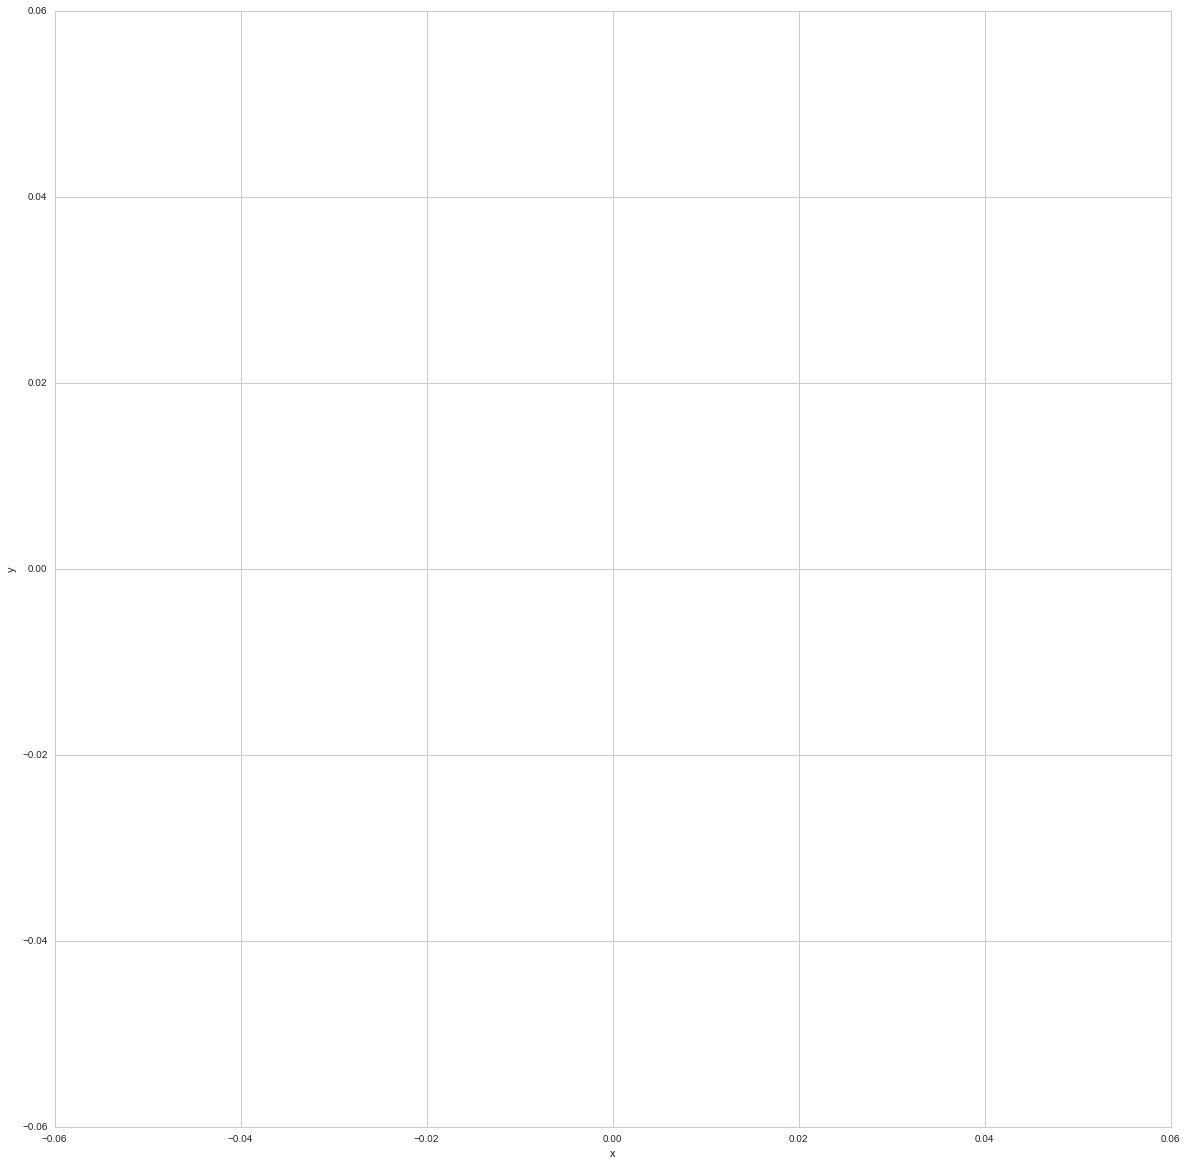

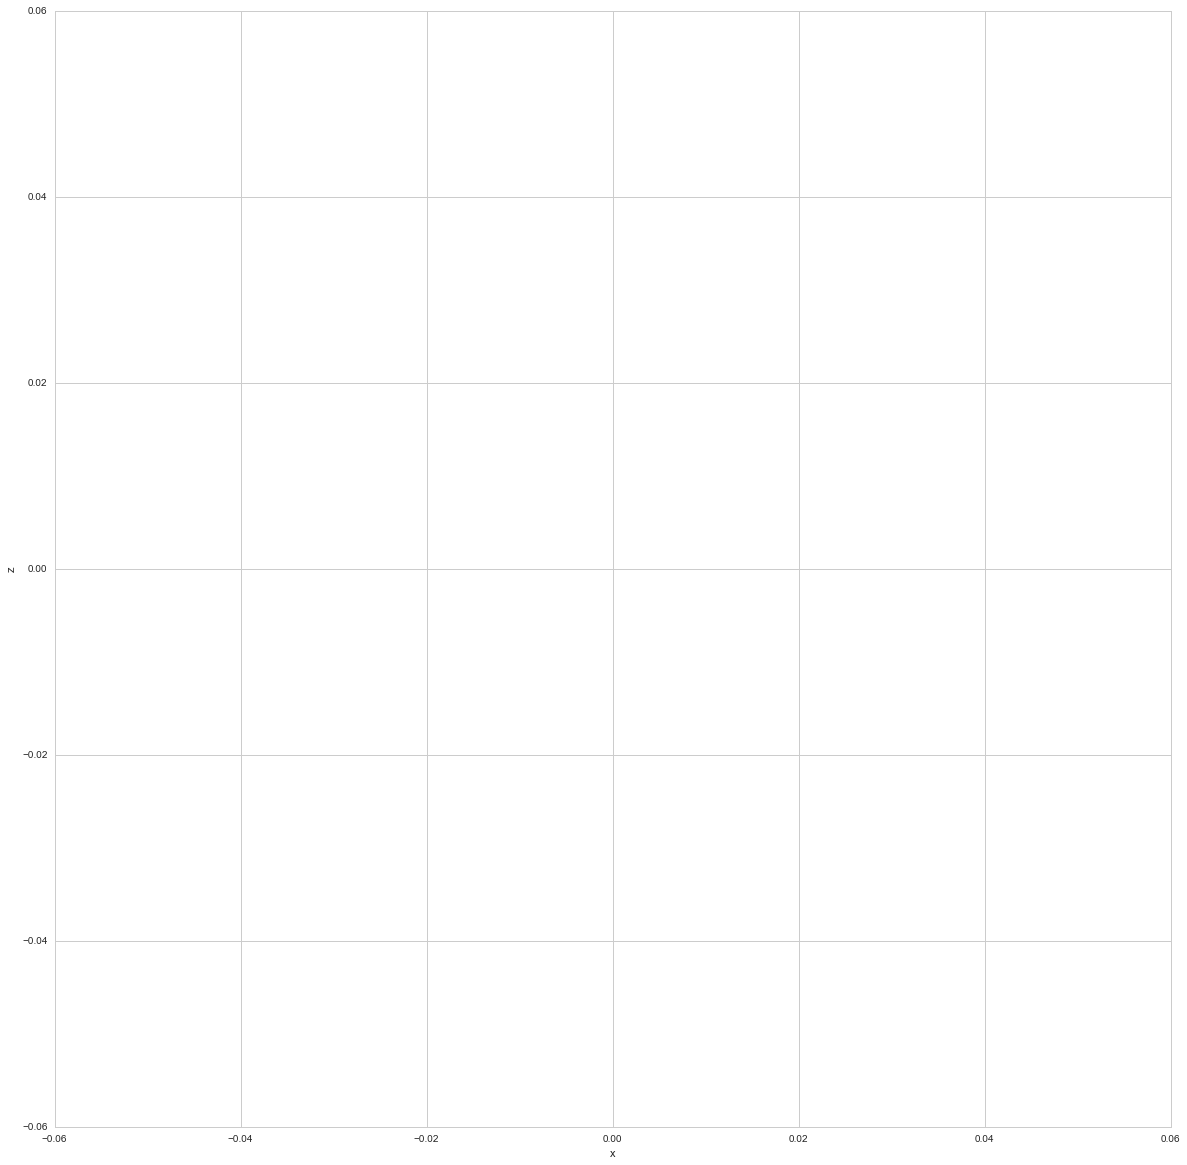

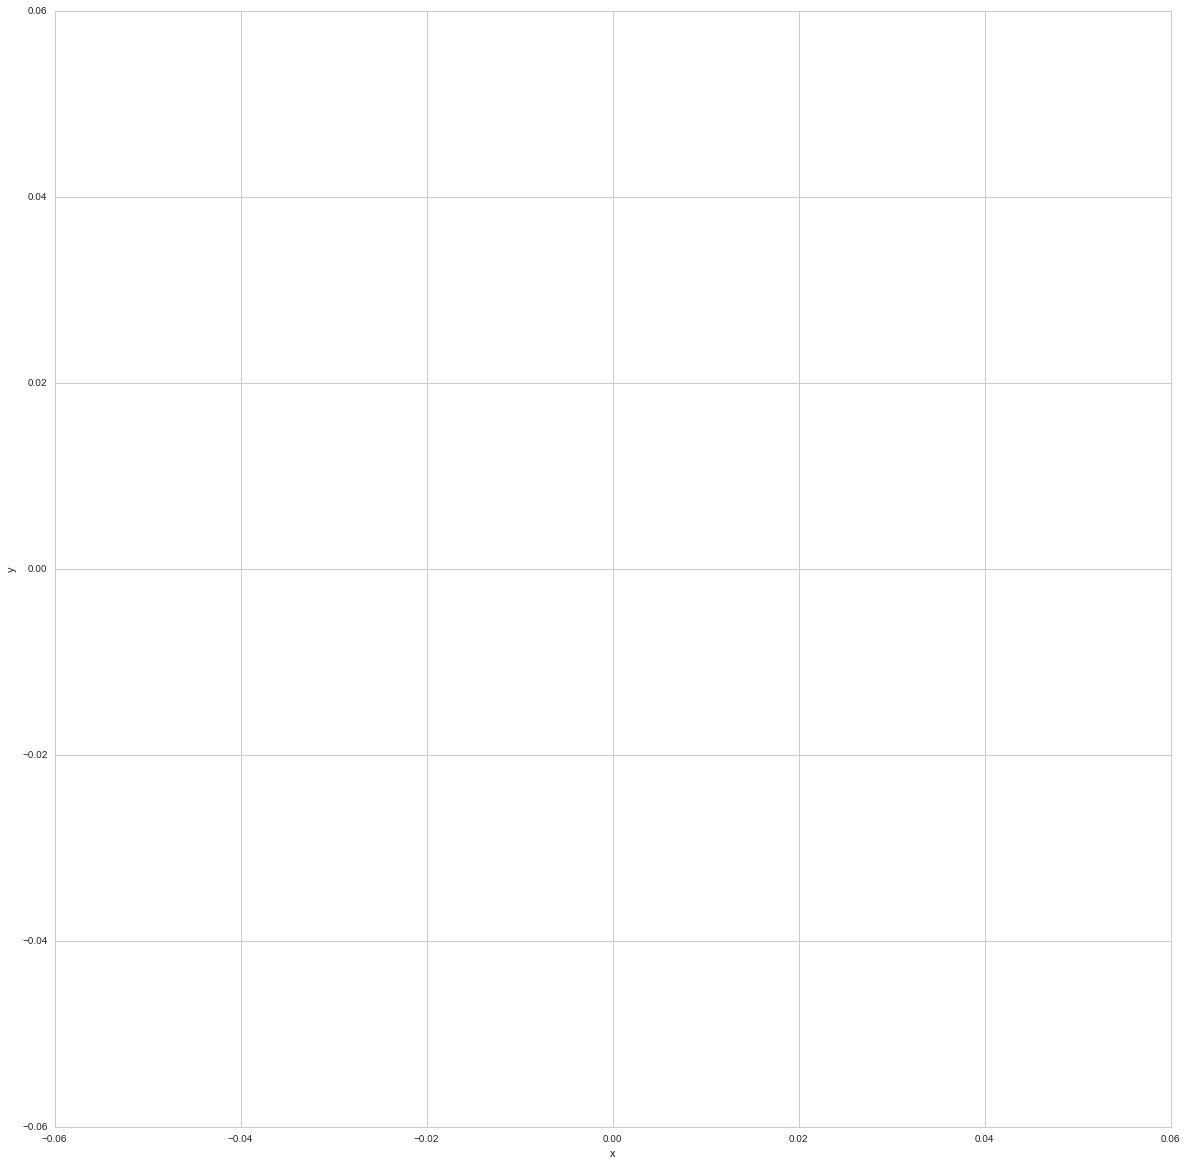

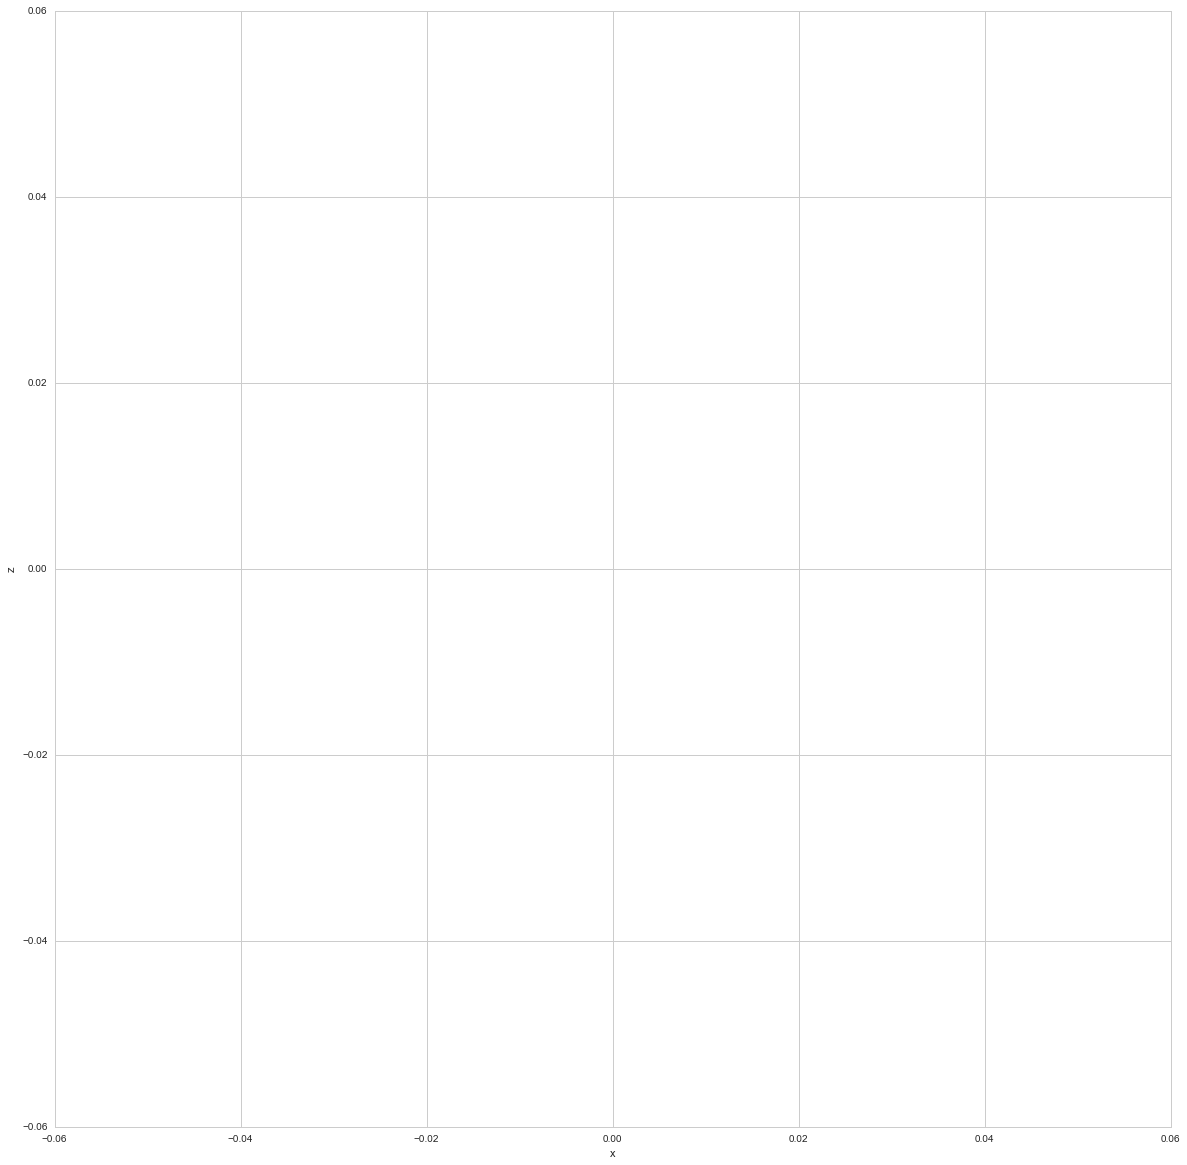

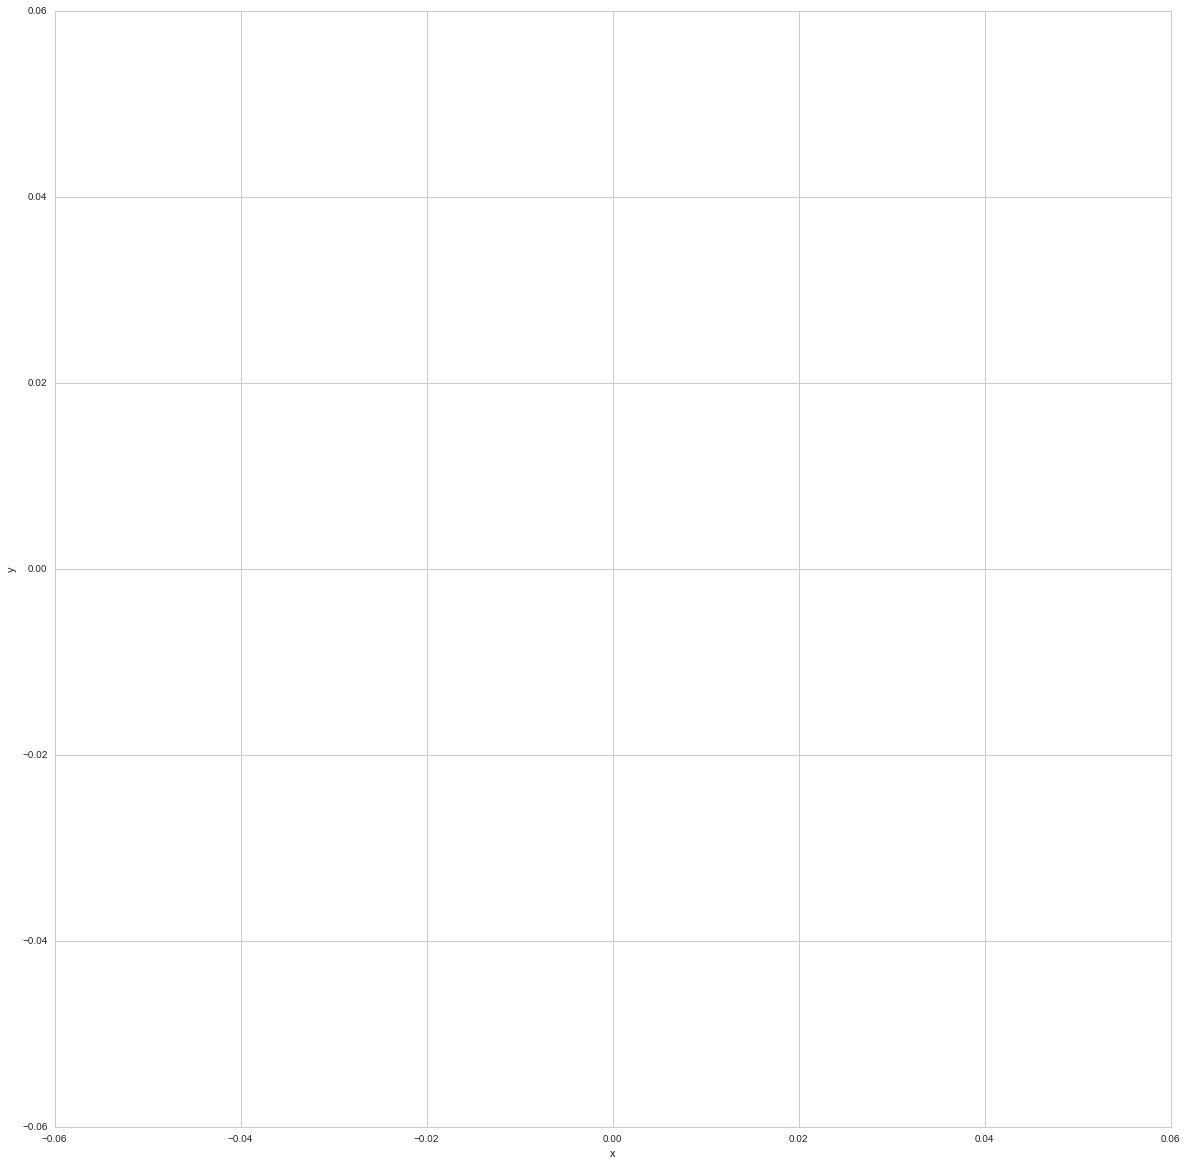

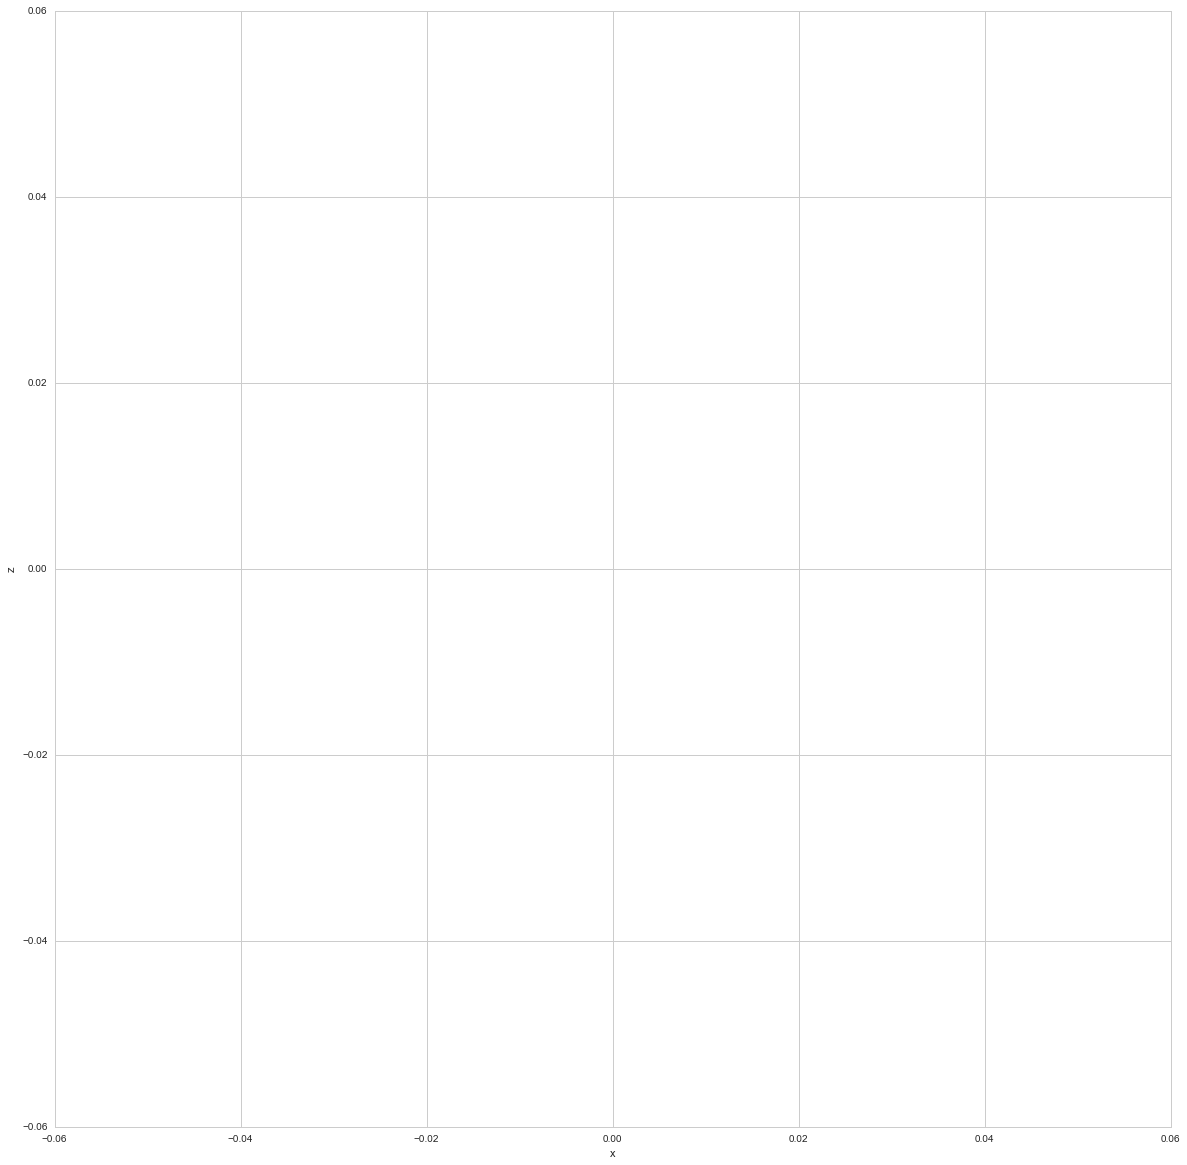

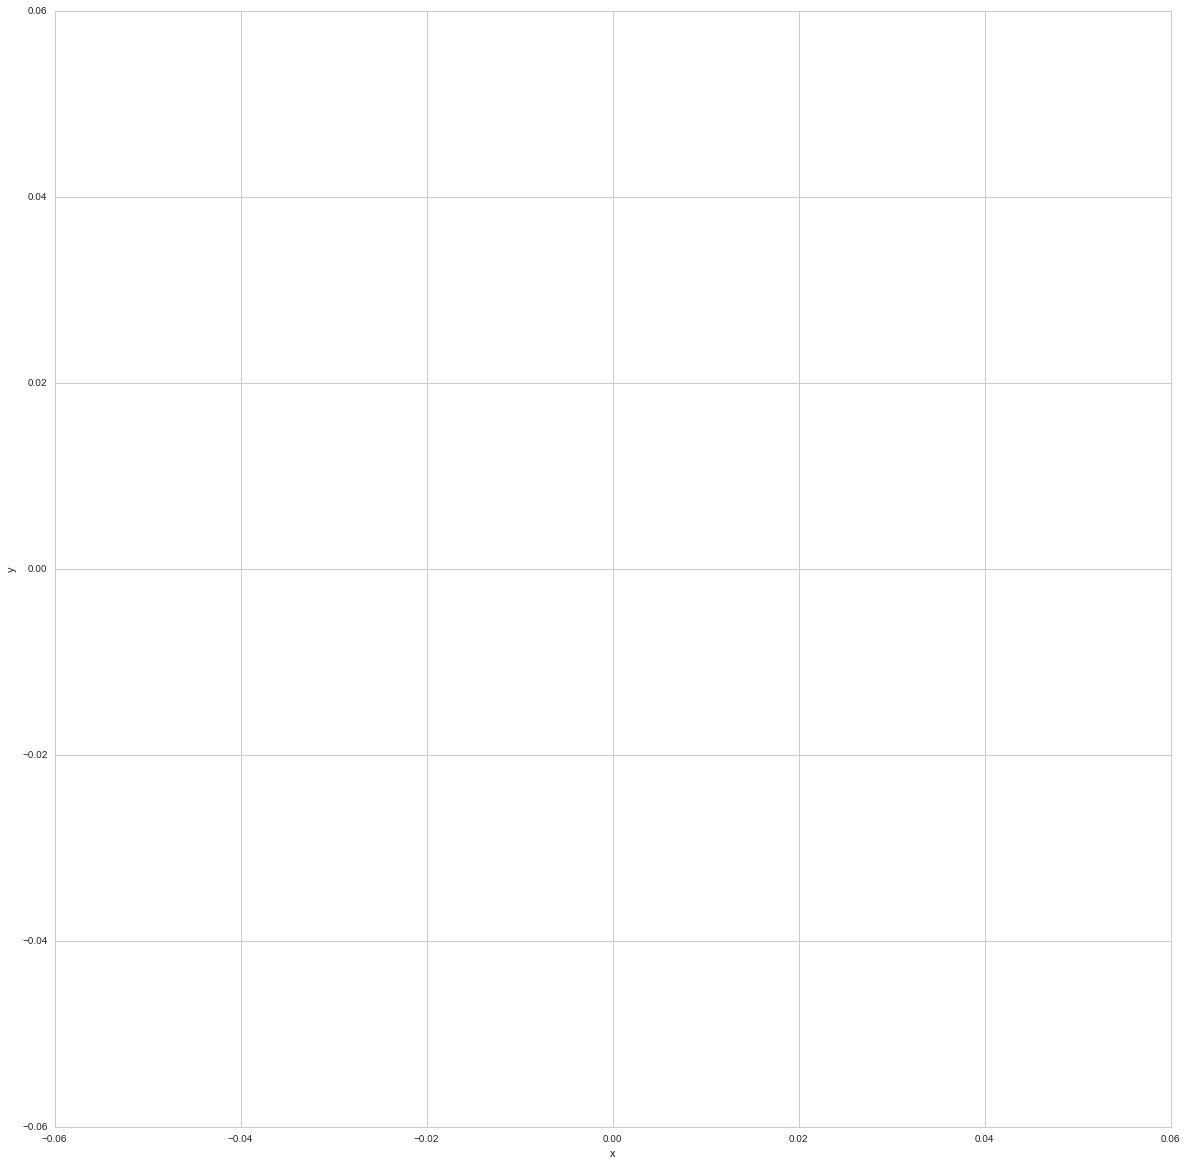

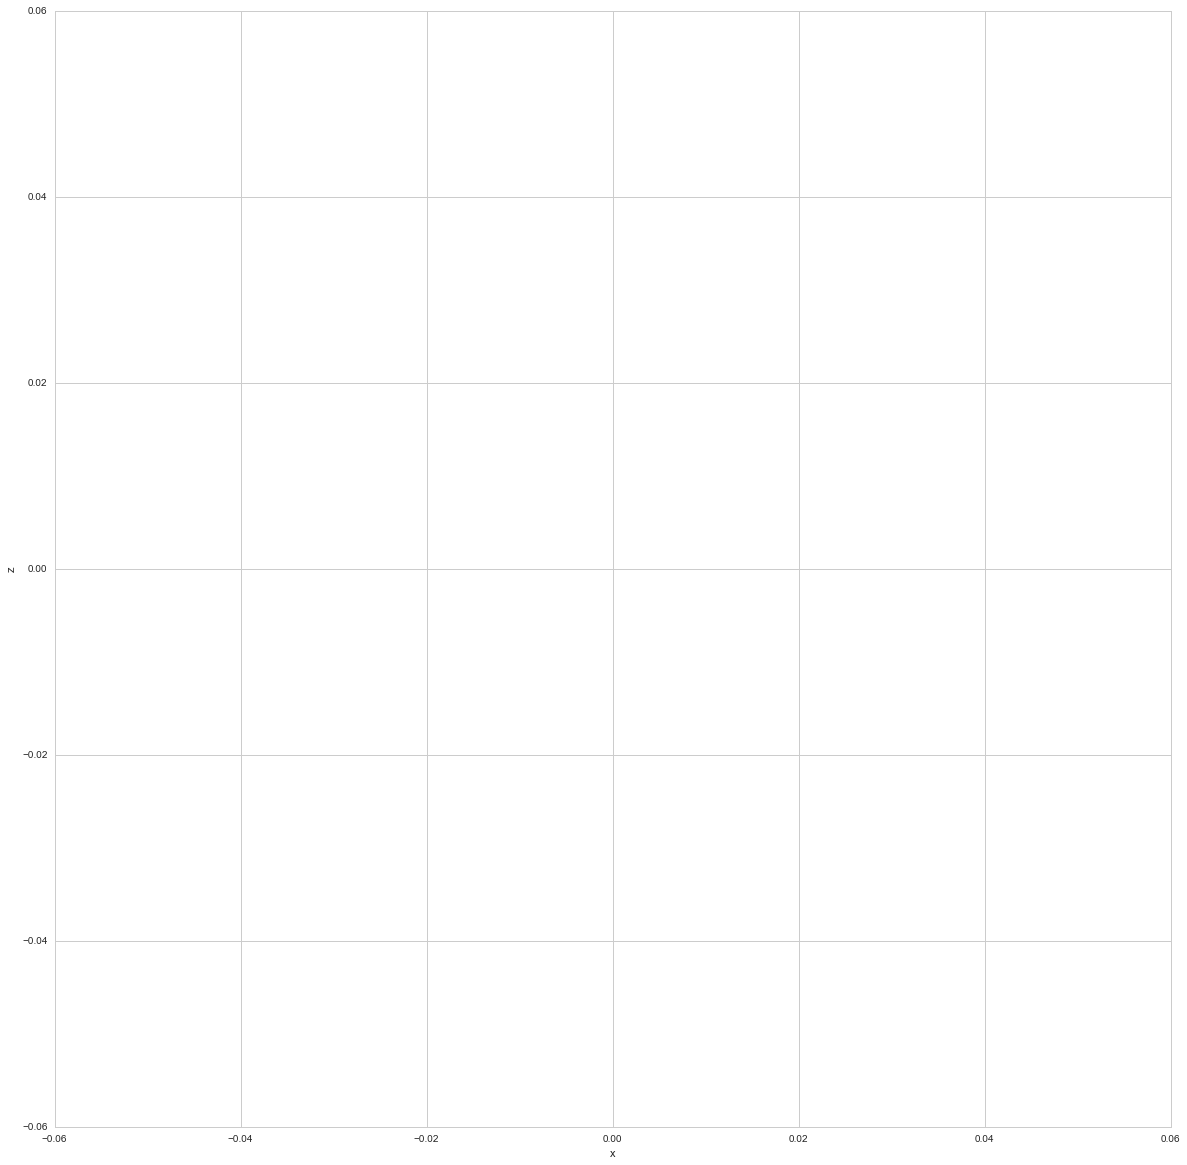

In [1067]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

for mbon_id, mbon_rosettes in all_rosette_df.groupby('body ID_post'):
    mbon_name = neuronsdf.ix[mbon_id].name_clean
    a = mbon_rosettes # all_rosette_df[all_rosette_df['body ID_post'] == tgt_id]
    thold = 20
    b = a[a.rosette_thold == thold]
    zdim = 2700, 3100
    xdim = 4000, 4300
    ydim = 6000, 6300
    c = b[(b.loc_x_post > xdim[0]) & (b.loc_x_post < xdim[1]) & \
         (b.loc_y_post > ydim[0]) & (b.loc_y_post < ydim[1]) &\
         (b.loc_z_post > zdim[0]) & (b.loc_z_post < zdim[1])]



    for coord1, coord2 in [('x', 'y'), ('x', 'z')]:
        fig =pylab.figure(figsize=(20, 20))
        ax = fig.add_subplot(1, 1,1 )

        coord_x_pre = 'loc_{}_pre'.format(coord1)
        coord_y_pre = 'loc_{}_pre'.format(coord2)
        coord_x_post = 'loc_{}_post'.format(coord1)
        coord_y_post = 'loc_{}_post'.format(coord2)

        ax.scatter(c[coord_x_post], c[coord_y_post], 
                   edgecolor='none', c='b', s=50, alpha=0.2)
        ax.scatter(c[coord_x_pre], c[coord_y_pre], 
                   edgecolor='none', c='g', s=50, alpha=0.4)
        ax.quiver(c[coord_x_pre], c[coord_y_pre],
                  c[coord_x_post] - c[coord_x_pre], 
                  c[coord_y_post] - c[coord_y_pre], 
                  scale_units='xy', angles='xy', scale=1, width=0.003, 
                  minlength=0.1, headlength=4, headwidth=4, alpha=0.7) # , headlength=0.1)
        #ax.set_xlim(*xdim)
        #ax.set_ylim(*ydim)


        # now try and plot the rosetts:
        patches = []
        for ri, r in c.groupby('rosette_id'):
            if len(r) > 1:
                r_m = r.mean()
                ax.scatter([r_m[coord_x_post]], [r_m[coord_y_post]], c='r')
                circ = mpatches.Circle((r_m[coord_x_post], r_m[coord_y_post]), thold)
                patches.append(circ)
        ax.add_collection(PatchCollection(patches, facecolor='none'))

        ax.set_xlabel(coord1)
        ax.set_ylabel(coord2)
        fig.savefig("rosette.{}.{}.{}.{}.pdf".format(mbon_id, thold, coord1, coord2))
#for ri, r in c.iterrows():
#    ax.arrow("", xy=(c.loc_x_pre, c.loc_y_pre), xycoords='data' ,
#             xytext=(c.loc_x_post, c.loc_y_post), textcoords='data')


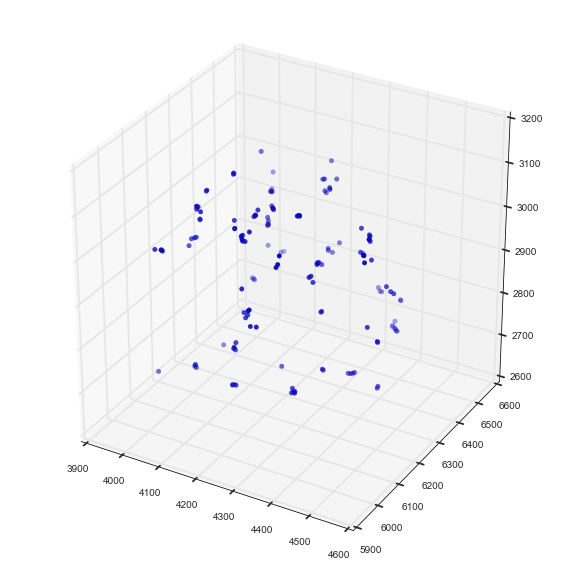

In [1046]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(c.loc_x_post, c.loc_y_post, c.loc_z_post)

In [1068]:


#res = []
rosette_res = []

for convergent in [False, True]:
    if convergent:
        pre_df = dfmerged[(dfmerged['convergent'] == 'convergent')]
    else:
        pre_df = dfmerged

    for ni, n in neuronsdf[neuronsdf.name_clean.str[:4] == 'MBON'].iterrows():

        mbons_post = pre_df[(pre_df['body ID_post'] == ni) ].copy()

        postsyn_vector = np.zeros((len(mbons_post), 3))
        postsyn_vector[:, 0] = mbons_post.loc_x_post
        postsyn_vector[:, 1] = mbons_post.loc_y_post
        postsyn_vector[:, 2] = mbons_post.loc_z_post
        for thold in [10, 20, 30, 40]:
            ng = sklearn.neighbors.radius_neighbors_graph(postsyn_vector, thold, include_self=True)
            cc = scipy.sparse.csgraph.connected_components(ng)[1]
            #unique = np.array(pd.value_counts(cc))

            mbons_post['rosette'] = cc
            mbons_post['rosette_thold'] = thold
            mbons_post['post_name'] = n.name_clean
            mbons_post['body ID_post'] == ni
            mbons_post['convergent_filtered'] = convergent

            rosette_res.append(mbons_post)
            break
        break
    break

            #res.append(d)
#cluster_sizes = pd.concat(res)

rosette_df = pd.concat(rosette_res).reset_index()
rosette_df['rosette_id'] = rosette_df.apply(lambda x : "%s:%d" % (x.post_name, 
                                                                  x.rosette), 
                                            axis=1)
